# Segmentation of e-commerce customers

In [1]:
from pyspark import SparkContext, SparkConf

In [2]:
conf = SparkConf()
conf.setAppName("customer_segmentation")
conf.setMaster("local[*]")
sc = SparkContext(conf=conf)

In [3]:
server = "12"
filename = "hdfs://kddrtserver{0}.isti.cnr.it:9000/user/hpsa05/data.csv".format(server)
data_rdd = sc.textFile(filename)
tot_record = data_rdd.count()
print('Numero di record:', tot_record)
print(data_rdd.take(5))

Numero di record: 541910
['InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country', '536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom', '536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom', '536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom', '536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom']


## Pre-Processing

In [4]:
from datetime import datetime
import re
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
header = data_rdd.first()
print('Header: ', header)

Header:  InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


**Verifica record duplicati**

In [7]:
# Filter out duplicates
distinctTuplesRdd = data_rdd.distinct()
cd = distinctTuplesRdd.count()
print('Numero di record totali {0} di cui duplicati {1} ({2}%):'.format(tot_record, tot_record-cd, round((tot_record-cd)/tot_record*100, 2)))
data_rdd = distinctTuplesRdd

Numero di record totali 541910 di cui duplicati 5268 (0.97%):


In [8]:
def clean_data(line):
    # eliminazione della virgola nella descrizione, in quanto crea problemi con la divisione degli attributi
    tokens = re.sub(',(?=[^"]*"[^"]*(?:"[^"]*"[^"]*)*$)',' ', line).split(',')
    tokens[2] = tokens[2].lower().replace(',', ' ').replace("'", '')
    tokens[3] = float(tokens[3]) if tokens[3] != '' else float('NaN')
    # Eliminazione del valore ora
    tokens[4] = datetime.strptime(tokens[4], '%m/%d/%Y %H:%M').date().strftime("%Y-%m-%d")
    tokens[5] = float(tokens[5]) if tokens[5] != '' else float('NaN')
    tokens[7] = tokens[7].lower()
    return tokens

In [9]:
clean_rdd = data_rdd.filter(lambda l: l != header)\
                    .map(clean_data)
clean_rdd.take(1)

[['536365',
  '84406B',
  'cream cupid hearts coat hanger',
  8.0,
  '2010-12-01',
  2.75,
  '17850',
  'united kingdom']]

**Verifica valori nulli**

In [10]:
def isNaN(x):
    if (type(x) == 'float') and (math.isnan(x)):
        return True
    if x == '':
        return True
    return False

In [11]:
cols = ['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']

for i, col in enumerate(cols):
    c = clean_rdd.filter(lambda x: isNaN(x[i])).count()
    perc = round(c/tot_record*100, 2)
    print('Numero di righe vuote per la colonna {0}: {1} ({2}%)'.format(col, c, perc))

Numero di righe vuote per la colonna InvoiceNo: 0 (0.0%)
Numero di righe vuote per la colonna StockCode: 0 (0.0%)
Numero di righe vuote per la colonna Description: 1454 (0.27%)
Numero di righe vuote per la colonna Quantity: 0 (0.0%)
Numero di righe vuote per la colonna InvoiceDate: 0 (0.0%)
Numero di righe vuote per la colonna UnitPrice: 0 (0.0%)
Numero di righe vuote per la colonna CustomerID: 135037 (24.92%)
Numero di righe vuote per la colonna Country: 0 (0.0%)


**CustomerID vuoti**
<p>Vediamo se è possibile recuperare il customerID dall'InvoiceNo, andando a controllare se per valore di InvoiceNo in cui non è presente il customerID è presente un record con stesso valore di InvoiceNo con customerID non vuoto</p>

In [12]:
empty_rdd = clean_rdd.filter(lambda x: x[6] == '').map(lambda x: (x[0], x[6]))
check_rdd = clean_rdd.filter(lambda x: x[6] != '').map(lambda x: (x[0], x[6]))

In [13]:
empty_rdd.take(1)

[('536544', '')]

In [14]:
check_rdd.take(1)

[('536365', '17850')]

In [15]:
check_customer = empty_rdd.leftOuterJoin(check_rdd)
check_customer.take(5)

[('536640', ('', None)),
 ('536640', ('', None)),
 ('536640', ('', None)),
 ('536640', ('', None)),
 ('536640', ('', None))]

In [16]:
check = check_customer.filter(lambda x: False if x[1][1] is None else True)
check.count()

0

Non è quindi possibile risalire al customerID, quindi eliminiamo i customerID vuoti

In [17]:
clean_rdd = clean_rdd.filter(lambda x: x[6] != '')

In [18]:
# rdd 
rdd_somma_record = clean_rdd.map(lambda line: [line[0], line[4],line[3]*line[5], line[6], line[7]])
rdd_somma_record.take(4)

[['536365', '2010-12-01', 22.0, '17850', 'united kingdom'],
 ['536365', '2010-12-01', 20.34, '17850', 'united kingdom'],
 ['536367', '2010-12-01', 9.899999999999999, '13047', 'united kingdom'],
 ['536367', '2010-12-01', 14.850000000000001, '13047', 'united kingdom']]

Passiamo da una visualizzazione relazionale a una transazionale raggruppando per customerID

In [18]:
# customerID, spesa_anno, freq_anno, num_mesi_acquisto, reso_anno

**Spesa totale per invoice**

In [19]:
rdd_somma_invoice = rdd_somma_record.map(lambda x: ((x[0], x[1], x[3], x[4]),x[2]))\
                                    .reduceByKey(lambda x,y:x+y)\
                                    .map(lambda x: [x[0][0], x[0][1], x[0][2], x[0][3], x[1]])
rdd_somma_invoice.take(2)
# (InvoiceId, Date, CustomerID, Country),  Spesa

[['536367', '2010-12-01', '13047', 'united kingdom', 278.73],
 ['536368', '2010-12-01', '13047', 'united kingdom', 70.05000000000001]]

In [20]:
num_invoice = rdd_somma_invoice.count()
print('Totale fatture: {}'.format(num_invoice))

Totale fatture: 22190


**Min Max Date**

In [21]:
date = clean_rdd.map(lambda x: datetime.strptime(x[4], '%Y-%m-%d')).cache()
print(date.min())
print(date.max())

2010-12-01 00:00:00
2011-12-09 00:00:00


**Distribuzione per country**

Notiamo che ci sono customer che presentano valori diversi di country

In [192]:
country_rdd = rdd_somma_invoice.map(lambda x: ((x[2], x[3]), 1))\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: (x[0][0], 1))\
                .reduceByKey(lambda x, y: x+y)\
.filter(lambda x: x[1]>1)
print('Numero di customer con acquisti in diversi country',country_rdd.count())
# Numero di acquisti per country
count_country = rdd_somma_invoice.map(lambda x: (x[3], 1))\
                                 .reduceByKey(lambda x, y: x+y)\
                                 .sortBy(lambda a: -a[1])
country = count_country.map(lambda x: x[0]).collect()
count = count_country.map(lambda x: x[1]).collect()

Numero di customer con acquisti in diversi country 8


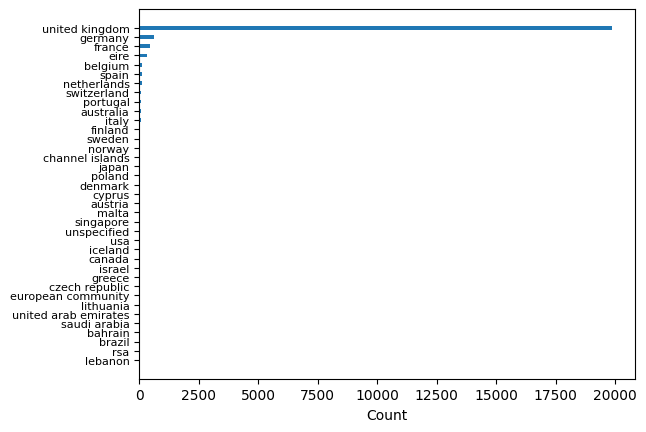

In [193]:
# Distribuzione degli acquisti nei diversi country
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(country))

ax.barh(y_pos, count, height=0.4)
ax.set_yticks(y_pos)
ax.set_yticklabels(country)
ax.tick_params(axis='y', labelsize=8)
ax.invert_yaxis()  # labels read top-to-bottom
#ax.set_xscale('log')
ax.set_xlabel('Count')
ax.set_title('')
plt.show()

In [24]:
tot_UK = rdd_somma_invoice.filter(lambda x: x[3] == 'united kingdom').count()
print('Numero di acquisti effettuati in UK {0} ({1}%)'.format(tot_UK, round(tot_UK/num_invoice*100, 2)))

Numero di acquisti effettuati in UK 19857 (89.49%)


## Feature extraction

In [25]:
stagioni = ['Estate', 'Inverno']
titoli = ['Totale_spesa', 'Frequenza_acquisti', 'Numero_distinti_mesi_acquisti', 'Totale_reso', 'Percentuale_reso']

In [26]:
def unpack_rdd(x):
    return [x[0], x[1][0][0][0][0], x[1][0][0][0][1], x[1][0][0][1], abs(x[1][0][1]), x[1][1] ]

In [27]:
# Funzione che crea i diversi attributi
def create_rdd_feature(rdd):
    # Totale spesa annuale
    rdd_spesa_anno_cliente = rdd.filter(lambda x: 'C' not in x[0])\
                                .map(lambda x: (x[2], x[4]))\
                                .reduceByKey(lambda x,y: x+y)
    # Frequenza di acquisto
    rdd_frequenza_cliente = rdd.filter(lambda x: 'C' not in x[0])\
                                .map(lambda x: (x[2], 1))\
                                .reduceByKey(lambda x,y: x+y)
    # Totale resi
    rdd_reso_anno_cliente = rdd.filter(lambda x: 'C' in x[0])\
                               .map(lambda x: (x[2], x[4]))\
                               .reduceByKey(lambda x,y: x+y)
    # frequenza resi
    rdd_invoice_reso_anno_cliente = rdd.filter(lambda x: 'C' in x[0])\
                                       .map(lambda x: (x[2], 1))\
                                       .reduceByKey(lambda x,y: x+y)
    # Precentuale resi
    perc_resi = rdd_spesa_anno_cliente.leftOuterJoin(rdd_reso_anno_cliente)\
                                  .filter(lambda x: x[1][0] != 0)\
                                  .map(lambda x: (x[0], 0 if (x[1][1] is None) else round(abs(x[1][1]/x[1][0])*100, 2)))
    # Numero mesi distincti in cui ci sono stati acquisti
    num_mesi_acquisto = rdd.map(lambda x: ((x[2], x[1][:7]), 1))\
                           .reduceByKey(lambda x, y: x+y)\
                           .map(lambda x: (x[0][0], 1))\
                           .reduceByKey(lambda x, y: x+y)
    # Combinazione feature
    data = rdd_spesa_anno_cliente.join(rdd_frequenza_cliente)\
                          .join(num_mesi_acquisto)\
                          .join(rdd_reso_anno_cliente)\
                          .join(perc_resi)\
                          .map(unpack_rdd)
    return data

Dividiamo il dataset in base alla stagione (primavera-estate/autunno-inverno) e calcoliamo gli attributi

In [28]:
# Creazione rdd per periodo invernale ed estivo
rdd_inverno = rdd_somma_invoice.filter(lambda x: True if (int(x[1][5:7]) > 8) or (int(x[1][5:7]) < 3) else False)
rdd_estate = rdd_somma_invoice.filter(lambda x: True if (int(x[1][5:7]) < 9) and (int(x[1][5:7]) > 2) else False)

In [29]:
data_inverno = create_rdd_feature(rdd_inverno)
data_estate = create_rdd_feature(rdd_estate)
ci = data_inverno.count()
ce = data_estate.count()

In [30]:
print('Numero di record in inverno {0} ({1}%)'.format(ci, ci/(ce+ci)*100))
print('Numero di record estate {0} ({1}%)'.format(ce, ce/(ce+ci)*100))

Numero di record in inverno 1059 (54.67217346411978%)
Numero di record estate 878 (45.32782653588023%)


In [203]:
data_estate.take(2)
#'CustomerID', 'Totale_spesa', 'Frequenza_acquisti', 'Numero_distinti_mesi_acquisti', 'Totale_reso', 'Percentuale_reso']

[['15194', 2263.42, 6, 5, 23.25, 1.03],
 ['18075', 1347.1, 5, 5, 40.230000000000004, 2.99]]

### Statistiche

In [89]:
from pyspark.mllib.stat import Statistics
import matplotlib
import numpy as np

In [34]:
# Calcolo media, deviazione standard, valore minimo e massimo
def calcolo_statistiche(data, titoli):  
    summary = Statistics.colStats(data)

    media = summary.mean()
    varianza = summary.variance()
    min = summary.min()
    max = summary.max()
    
    for a, m, v, mi, ma in zip(titoli, media, varianza, min, max):
        print('- {}:\nmedia: {} \nstd: {} \nmin: {}\nmax: {}'.format(a,round(m,2),round(np.sqrt(v),2), round(mi, 2), round(ma,2)))

In [35]:
# Plot delle distribuzioni degli attributi
def plot_stat(data, titoli):
    spesa_anno_l = data.map(lambda x: x[1]).collect()
    freq_anno_l = data.map(lambda x: x[2]).collect()
    num_mesi_acquisto_l = data.map(lambda x: x[3]).collect()
    reso_anno_l = data.map(lambda x: x[4]).collect()
    per_reso_l = data.map(lambda x: x[5]).collect()
    
    fig = plt.figure(figsize=(20,10))
    fig_dims = (4,3)   
    variabili = [spesa_anno_l, freq_anno_l, num_mesi_acquisto_l, reso_anno_l, per_reso_l]
    r=0
    i=0
    for v, t in zip(variabili, titoli):  
        if i>2:
            r+=1
            i=0
        plt.subplot2grid(fig_dims, (r,i))
        plt.hist(v, bins= 50, log=True, rwidth=0.8, alpha= 0.8)
        plt.title(t)
        i+=1

    plt.show()

Estate
- Totale_spesa:
media: 2732.42 
std: 7780.51 
min: 17.55
max: 118489.92
- Frequenza_acquisti:
media: 4.85 
std: 6.59 
min: 1.0
max: 83.0
- Numero_distinti_mesi_acquisti:
media: 3.12 
std: 1.58 
min: 1.0
max: 6.0
- Totale_reso:
media: 213.69 
std: 1706.07 
min: 0.42
max: 39267.0
- Percentuale_reso:
media: 17.84 
std: 309.6 
min: 0.03
max: 9166.67


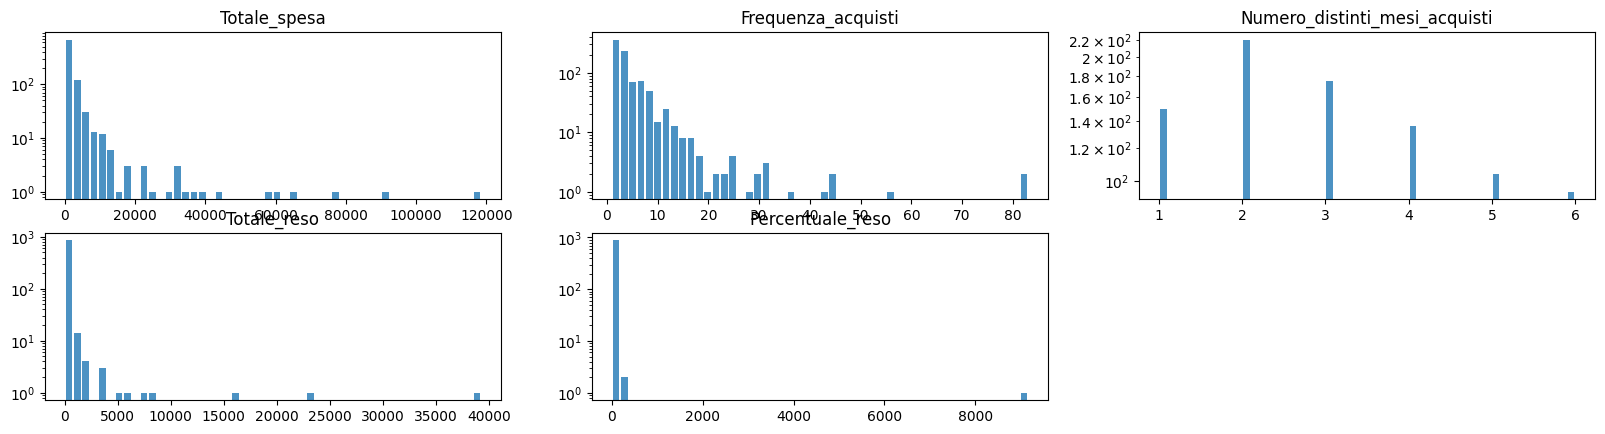

Correlazione Pearson 
 Totale_spesa, Frequenza_acquisti, Numero_distinti_mesi_acquisti, Totale_reso, Percentuale_reso
[[ 1.          0.52930663  0.34357612  0.34919959 -0.01137876]
 [ 0.52930663  1.          0.62525913  0.14473836 -0.02464951]
 [ 0.34357612  0.62525913  1.          0.00522853 -0.03531824]
 [ 0.34919959  0.14473836  0.00522853  1.          0.04631293]
 [-0.01137876 -0.02464951 -0.03531824  0.04631293  1.        ]] 

Inverno
- Totale_spesa:
media: 3072.74 
std: 10201.69 
min: 3.35
max: 168469.6
- Frequenza_acquisti:
media: 5.09 
std: 7.68 
min: 1.0
max: 127.0
- Numero_distinti_mesi_acquisti:
media: 3.2 
std: 1.71 
min: 1.0
max: 7.0
- Totale_reso:
media: 383.98 
std: 5727.24 
min: 0.42
max: 168469.6
- Percentuale_reso:
media: 13.71 
std: 176.2 
min: 0.03
max: 5705.07


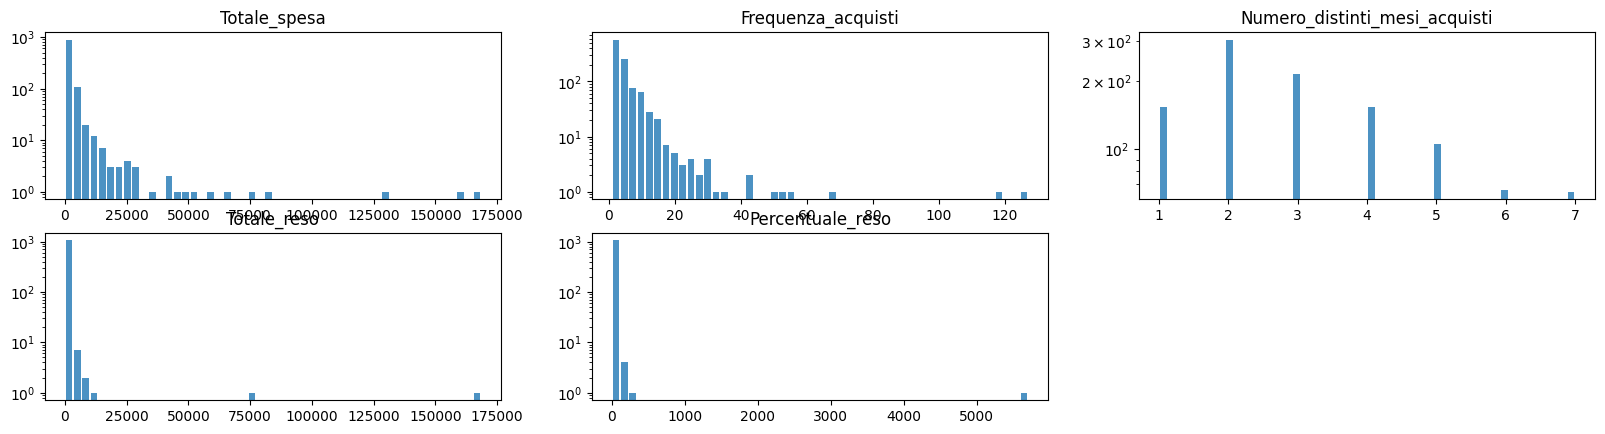

Correlazione Pearson 
 Totale_spesa, Frequenza_acquisti, Numero_distinti_mesi_acquisti, Totale_reso, Percentuale_reso
[[ 1.          0.47253499  0.26935281  0.59094963 -0.00206905]
 [ 0.47253499  1.          0.57261739  0.01608496 -0.02703422]
 [ 0.26935281  0.57261739  1.         -0.03759764 -0.04466878]
 [ 0.59094963  0.01608496 -0.03759764  1.          0.02657021]
 [-0.00206905 -0.02703422 -0.04466878  0.02657021  1.        ]] 



In [36]:
for i, data in enumerate([data_estate, data_inverno]):
    print(stagioni[i])
    feature = data.map(lambda x: x[1:])
    calcolo_statistiche(feature, titoli)
    plot_stat(data, titoli)
    t = ', '.join(titoli)
    print('Correlazione Pearson \n', t)
    print(Statistics.corr(feature, method = 'pearson'), '\n')    

In [37]:
# Presenza di outlier nell'attributo Reso
data_inverno_outlier = data_inverno.filter(lambda x: x[4] > 50000)
co = data_inverno_outlier.count()
c = data_inverno.count()
print('Inverno: Totale dati {0}, di cui outlier per reso {1} ({2}%)'.format(c, co, co/c*100))

data_estate_outlier = data_estate.filter(lambda x: x[4] > 15000)
co = data_estate_outlier.count()
c = data_estate.count()
print('Estate: Totale dati {0}, di cui outlier per reso {1} ({2}%)'.format(c, co, co/c*100))

Inverno: Totale dati 1059, di cui outlier per reso 2 (0.18885741265344666%)
Estate: Totale dati 878, di cui outlier per reso 3 (0.3416856492027335%)


In [38]:
# Presenza di outlier nell'attributo Totale speso
data_inverno_outlier = data_inverno.filter(lambda x: x[1] > 100000)
co = data_inverno_outlier.count()
count_inv = data_inverno.count()
print('Inverno: Totale dati {0}, di cui outlier per reso {1} ({2}%)'.format(count_inv, co, co/count_inv*100))

data_estate_outlier = data_estate.filter(lambda x: x[1] > 50000)
co = data_estate_outlier.count()
count_est = data_estate.count()
print('Estate: Totale dati {0}, di cui outlier per reso {1} ({2}%)'.format(count_est, co, co/count_est*100))

Inverno: Totale dati 1059, di cui outlier per reso 3 (0.28328611898017%)
Estate: Totale dati 878, di cui outlier per reso 6 (0.683371298405467%)


Eliminazione degli outlier

In [39]:
data_inverno = data_inverno.filter(lambda x: (x[4] <= 50000) and (x[1] <= 100000) and (x[5] < 5000))
data_estate = data_estate.filter(lambda x: (x[4] <= 15000) and (x[1] <= 50000) and (x[5] < 8000))

**Standard Scaler**

In [38]:
#from pyspark.mllib.feature import StandardScaler 

In [39]:
# label = data.map(lambda x: x[0])
# features = data.map(lambda x: [x[1:]])
# scaler = StandardScaler(withMean=True, withStd=True) 
# model = scaler.fit(features) 
# result = model.transform(features)
# calcolo_stats(result)

**Normalize**

In [42]:
from pyspark.mllib.feature import Normalizer 
from pyspark.mllib.linalg import Vectors

In [43]:
# Funzione utile per normalizzare separatamente ogni attributo, 
# in quanto la funzione Normalizer normalizza il DenseVector per singolo record
def features_norm(data, features=5):

    tmp_norm = list()
    norm_value = list()
    # customerID
    customerID = data.map(lambda x: x[0]).collect() 

    tmp_norm.append(customerID)

    for f in range(1, features+1):
        # seleziono la colonna (feature)
        colonna = data.map(lambda x: x[f])\
                          .collect()
        # massimo colonna
        norm_value.append(max(colonna))
        
        # trasformo la colonna un un denseVector
        vettore_colonna = Vectors.dense(colonna)

        # Norma della colonna
        norm = Normalizer(p=float("inf")) # normalizzo per il massimo valore
        vettore_colonna_norm = norm.transform(vettore_colonna)

        tmp_norm.append(vettore_colonna_norm)
        
    return list(zip(*tmp_norm)), norm_value   

In [44]:
data_norm_inv, norm_value_inv = features_norm(data_inverno)
data_inverno_norm = sc.parallelize(data_norm_inv)

data_norm_est, norm_value_est = features_norm(data_estate)
data_estate_norm = sc.parallelize(data_norm_est)

In [47]:
def plot_corr(data):
    spesa_l = data.map(lambda x: x[1]).collect()
    freq_l = data.map(lambda x: x[2]).collect()
    num_mesi_acquisto_l = data.map(lambda x: x[3]).collect()
    reso_l = data.map(lambda x: x[4]).collect()
    per_reso_l = data.map(lambda x: x[5]).collect()
    
    plt.scatter(spesa_l, freq_l)
    plt.xlabel('spesa')
    plt.ylabel('frequenza')
    plt.show()
    plt.scatter(num_mesi_acquisto_l, freq_l)
    plt.xlabel('num_mesi_acquisto')
    plt.ylabel('frequenza')
    plt.show()
    plt.scatter(spesa_l, per_reso_l)
    plt.xlabel('spesa')
    plt.ylabel('percentuale_reso')
    plt.show()

In [44]:
# plot_corr(data_inverno)

In [45]:
# plot_corr(data_estate)

## K-Means

In [48]:
from pyspark.mllib.clustering import KMeans 
import pandas as pd

**SSE**

In [49]:
# Calcolo della SSE
def error(point, model_kmeans):
    center = model_kmeans.centers[model_kmeans.predict(point)]
    return np.sqrt(sum([x**2 for x in (point - center)]))

In [50]:
def run_kmeans(dataset, k):
    model_kmeans = KMeans.train(dataset, k=k, initializationMode="kmeans", maxIterations=100)
    rdd_cluster_norm = dataset.map(lambda line: model_kmeans.predict(line))
    WSSSE = dataset.map(lambda point: error(point, model_kmeans)).reduce(lambda x, y: x + y) 
    return WSSSE, model_kmeans, rdd_cluster_norm

In [51]:
# Funzione che esegue il K-Means variando il valore di K, valutando quello che minimizza il valore di SSE
def scelta_k(dataset):
    sse_l = list()
    k_val = range(2, 41)
    for k in k_val:
        WSSSE, _, _= run_kmeans(dataset, k)
        sse_l.append(WSSSE)
        
    x = k_val
    y = sse_l
    #plt.figure(figsize=(10,10))
    plt.plot(x, y, marker='*')
    plt.tick_params(which='major')
    plt.grid()
    plt.ylabel('SSE')
    plt.xlabel('K')

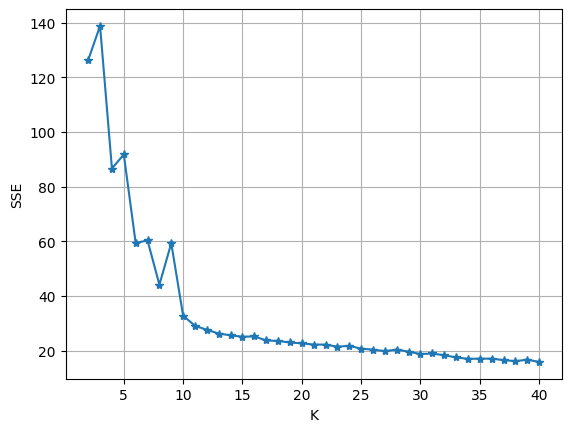

In [59]:
# Togliamo percentuale resi dal kmeans
data_inverno_norm_senza_resi = data_inverno_norm.map(lambda x: x[:-1])

scelta_k(data_inverno_norm_senza_resi.map(lambda x: x[1:]))

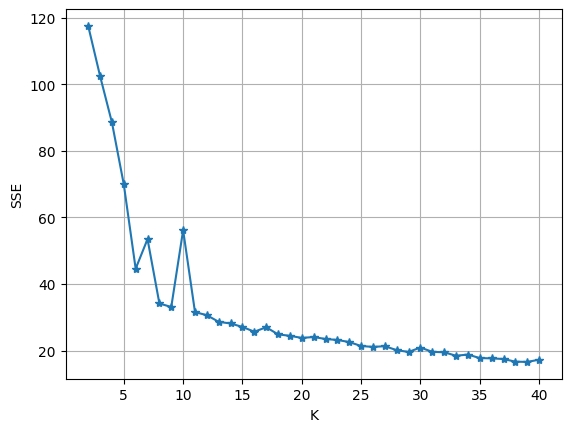

In [56]:
# Togliamo percentuale resi dal kmeans
data_estate_norm_senza_resi = data_estate_norm.map(lambda x: x[:-1])
scelta_k(data_estate_norm_senza_resi.map(lambda x: x[1:]))

Scegliamo k=6 poichè è quello che presenta la massima variazione del valore di SSE

In [60]:
k = 6

**Clustering Inverno**

In [61]:
WSSSE_inv, model_kmeans_inv, rdd_cluster_norm_inv = run_kmeans(data_inverno_norm_senza_resi.map(lambda x: x[1:]), k)
print('SSE: ', WSSSE_inv)

centroidi_inv_norm = model_kmeans_inv.clusterCenters
cluster_inv_norm = rdd_cluster_norm_inv.zip(data_inverno_norm_senza_resi)
#cluster_inv = rdd_cluster_norm_inv.zip(data_inverno)

SSE:  45.68967607471733


In [62]:
# Customer in ogni cluster:
client_per_cluster_inv = cluster_inv_norm.map(lambda c: (c[0], 1))\
                                    .reduceByKey(lambda x,y: x+y)
coppie_cluster = client_per_cluster_inv.sortByKey().collect()
for c in coppie_cluster:
    print("Cluster {0} num customer {1} ({2}%)".format(c[0], c[1], round(c[1]/count_inv*100, 4)))

Cluster 0 num customer 214 (20.2077%)
Cluster 1 num customer 74 (6.9877%)
Cluster 2 num customer 151 (14.2587%)
Cluster 3 num customer 161 (15.203%)
Cluster 4 num customer 152 (14.3532%)
Cluster 5 num customer 302 (28.5175%)


In [55]:
# #cluster_list = cluster.map(lambda x: [x[0], x[1][0], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4]]).collect()
# #cluster_list_inv = cluster_inv.map(lambda x: [x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4], x[1][5]]).collect()

# #cluster_list_inv_norm = cluster_inv_norm.map(lambda x: [x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4], x[1][5]]).collect()
# cluster_list_inv_norm = cluster_inv_norm.map(lambda x: [x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4]]).collect()

**Clustering Estate**

In [63]:
WSSSE_est, model_kmeans_est, rdd_cluster_norm_est = run_kmeans(data_estate_norm_senza_resi.map(lambda x: x[1:]), k)
print('SSE: ', WSSSE_est)

centroidi_est_norm = model_kmeans_est.clusterCenters
cluster_est_norm = rdd_cluster_norm_est.zip(data_estate_norm_senza_resi)
#cluster_est = rdd_cluster_norm_est.zip(data_estate)

SSE:  61.39475582887026


In [64]:
# Customer in ogni cluster:
client_per_cluster_est = cluster_est_norm.map(lambda c: (c[0], 1))\
                                    .reduceByKey(lambda x,y: x+y)
coppie_cluster = client_per_cluster_est.sortByKey().collect()
for c in coppie_cluster:
    print("Cluster {0} num customer {1} ({2}%)".format(c[0], c[1], round(c[1]/count_est*100, 4)))

Cluster 0 num customer 102 (11.6173%)
Cluster 1 num customer 393 (44.7608%)
Cluster 2 num customer 136 (15.4897%)
Cluster 3 num customer 147 (16.7426%)
Cluster 4 num customer 77 (8.7699%)
Cluster 5 num customer 13 (1.4806%)


In [58]:
# #cluster_list_est = cluster_est.map(lambda x: [x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4], x[1][5]]).collect()
# # cluster_list_est_norm = cluster_est_norm.map(lambda x: [x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4], x[1][5]]).collect()
# cluster_list_est_norm = cluster_est_norm.map(lambda x: [x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4]]).collect()

### Confronto tra clustering

**Denormalizzazione dei dati**

In [65]:
# funzione per denormalizzare le feature
def denorm(x, max_value, cols):
    y = []
    y.append(x[0])
    y.append(x[1][0])

    for i in range(1, cols):
        y.append(abs(x[1][i]) * max_value[i-1])
    return y

In [66]:
def denorm_centroidi(centroidi, norm_value_inv, cols):
    centroidi_denorm = list()
    for j in range(cols):
        centroidi_denorm.append(centroidi[j]*norm_value_inv[j])
    return centroidi_denorm

In [69]:
cluster_estate = cluster_est_norm.map(lambda x: denorm(x, norm_value_est, 5))
centroidi_est = [denorm_centroidi(centroidi_est_norm[i], norm_value_est, 4) for i in range(k)]

cluster_inverno = cluster_inv_norm.map(lambda x: denorm(x, norm_value_inv, 5))
centroidi_inv = [denorm_centroidi(centroidi_inv_norm[i], norm_value_inv, 4) for i in range(k)]

Trasformazione in dataframe per i plot

In [70]:
#cols_name = ['spesa_tot', 'frequenza', 'num_distinti_mesi_acquisto', 'reso', 'percentuale_resi']
cols_name = ['spesa_tot', 'frequenza', 'num_distinti_mesi_acquisto', 'reso']
cols_num = range(len(cols_name))
# rename per dataframe con i centroidi 
d = dict(zip(cols_num, cols_name))

# rename per dataframe con tutti i dati
cols_name_tot = ['label', 'customer'] + cols_name
cols_num_tot = range(len(cols_name_tot))
d_tot = dict(zip(cols_num_tot, cols_name_tot))

In [71]:
# inverno
cluster_list_inv = cluster_inverno.collect()
df_inv = pd.DataFrame(cluster_list_inv)
df_inv.rename(columns=d_tot, inplace=True)
# centroidi
df_centroidi_inv = pd.DataFrame(centroidi_inv)
df_centroidi_inv.rename(columns=d, inplace=True)


# estate
cluster_list_est = cluster_estate.collect()
df_est = pd.DataFrame(cluster_list_est)
df_est.rename(columns=d_tot, inplace=True)
# centroidi
df_centroidi_est = pd.DataFrame(centroidi_est)
df_centroidi_est.rename(columns=d, inplace=True)

In [184]:
df_centroidi_inv

,spesa_tot,frequenza,num_distinti_mesi_acquisto,reso
0,1399.228037,3.574766,3.000000,85.535794
1,14377.724189,20.581081,6.797297,725.193919
2,682.353179,1.304636,1.000000,83.861788
3,3688.300745,8.105590,5.360248,97.695714
4,2312.842039,5.414474,4.000000,88.210329
5,1011.336556,2.341060,2.000000,132.396391


In [117]:
df_centroidi_est

,spesa_tot,frequenza,num_distinti_mesi_acquisto,reso
0,3088.259608,7.294118,5.000000,104.533922
1,1082.358908,2.575064,2.442748,78.676870
2,2208.325956,5.007353,3.992647,85.907132
3,494.616395,1.183673,1.000000,68.083673
4,4964.163247,13.272727,5.987013,105.485974
5,25865.438462,30.769231,5.769231,1646.334615


**Plot cluster**

In [72]:
from itertools import combinations

In [73]:
# creazione combinazione di tutte le possibili coppie per plot
coppie = list(combinations(cols_name, 2))

In [74]:
coppie

[('spesa_tot', 'frequenza'),
 ('spesa_tot', 'num_distinti_mesi_acquisto'),
 ('spesa_tot', 'reso'),
 ('frequenza', 'num_distinti_mesi_acquisto'),
 ('frequenza', 'reso'),
 ('num_distinti_mesi_acquisto', 'reso')]

In [204]:
# Plot bidimensionale (uno per ogni coppia di attributi) per visualizzare i diversi cluster: 
# sia quelli relativi al clustering invernale che quelli relativi a quello estivo.
def plot_clusters(df_inv, df_centroidi_inv, df_est, df_centroidi_est, lim_d=None):
    fig, ax = plt.subplots(len(coppie), 2, figsize=(12, 20)) 
    ax = ax.ravel()
    idx = 0
    colors = ['purple', 'blue', 'green', 'orange', 'red', 'yellow']
    
    ax[0].set_title('Inverno')
    ax[1].set_title('Estate')
    labels_inv = df_inv['label']
    labels_est = df_est['label']

    for c in coppie:
        c1, c2 = c
        #ax[idx].scatter(df_inv[c1], df_inv[c2], s=20, c=labels_inv, alpha=0.3, cmap='rainbow')
        ax[idx].scatter(df_inv[c1], df_inv[c2], s=20, c=labels_inv, alpha=0.3, cmap=matplotlib.colors.ListedColormap(colors))
        ax[idx].scatter(df_centroidi_inv[c1], df_centroidi_inv[c2], s=200, c=np.unique(labels_inv),\
                     marker='*', edgecolors='black', cmap=matplotlib.colors.ListedColormap(colors))
        
        ax[idx].set_xlim(lim_d[c1])
        ax[idx].set_ylim(lim_d[c2])
              
        ax[idx].set_xlabel(c1)
        ax[idx].set_ylabel(c2)

        idx += 1

        ax[idx].scatter(df_est[c1], df_est[c2], s=20, c=labels_est, alpha=0.3, cmap=matplotlib.colors.ListedColormap(colors))
        ax[idx].scatter(df_centroidi_est[c1], df_centroidi_est[c2], s=200, c=np.unique(labels_est),\
                     marker='*', edgecolors='black', cmap=matplotlib.colors.ListedColormap(colors))

        ax[idx].set_xlim(lim_d[c1])
        ax[idx].set_ylim(lim_d[c2])

        ax[idx].set_xlabel(c1)
        ax[idx].set_ylabel(c2)

        idx += 1
                
    plt.show()  

In [185]:
# Plot bidimensionale (uno per ogni coppia di attributi) per singolo cluster.
def plot_per_cluster(df, stagione, lim_d, df_centroidi):
    colors = ['purple', 'blue', 'green', 'orange', 'red', 'yellow']
 
    for cluster in range(k):
        fig, ax = plt.subplots(len(coppie), 1, figsize=(6, 20)) 
        ax = ax.ravel()
        df_tmp = df[df['label']==cluster]
        df_centroidi_tmp = df_centroidi.take([cluster])
        
        idx = 0
        ax[0].set_title(stagione)

        labels = df_tmp['label']
        colore = colors[cluster]
        
        for c in coppie:
            c1, c2 = c

            ax[idx].scatter(df_tmp[c1], df_tmp[c2], s=20, c=colore, alpha=0.3)        
            ax[idx].scatter(df_centroidi_tmp[c1], df_centroidi_tmp[c2], s=200, c=colore,\
                     marker='*', edgecolors='black')
            ax[idx].set_xlim(lim_d[c1])
            ax[idx].set_ylim(lim_d[c2])
    
            ax[idx].set_xlabel(c1)
            ax[idx].set_ylabel(c2)
            idx += 1
        plt.savefig(stagione + '_cluster_'+ str(cluster) +'.png')
        #plt.show()  

In [110]:
def cluster_dist(data, inverse_param, features, stagione):
    fig = plt.figure(figsize=(80,50))
    fig_dims = (len(features), k)

    ax = []
    
    color = ['purple', 'blue', 'green', 'orange', 'red', 'yellow']

    for cluster in range(k):
        # raggruppo gli elementi per cluster
        # trasformata inversa
        rdd_cluster = data.filter(lambda x: x[0]==cluster)\
                          .map(lambda x: [x[1][1]*inverse_param[0],x[1][2]*inverse_param[1],
                                          x[1][3]*inverse_param[2],x[1][4]*inverse_param[3]])

        # distribuzioni {0: [[s],[f],[m],[r]], ...}

        distibruzioni = list()

        for f in range(len(features)):
            dist = rdd_cluster.map(lambda x: x[f]).collect()
            distibruzioni.append(dist)


        # Istogramma riga features colonna cluster
        asse = list()
        ax.append([])

        for r in range(len(features)):

            ax[-1].append(plt.subplot2grid(fig_dims,(r,cluster)))
            ax[-1][-1].hist(distibruzioni[r], bins= 50, log=True, rwidth=0.9, alpha= 0.8, color= color[cluster]) # ax[r]: asse per ciascuna features 
            plt.title('{}: Cluster {}'.format(stagione, cluster))
            plt.xlabel(features[r])


    in_ax = list(zip(*ax))

    for feature in in_ax:
        # prendo gli assi del primo cluster per feature
        min_x, max_x = feature[0].get_xlim()
        min_y, max_y = feature[0].get_ylim()

        for cluster in feature[1:]:

            tmp_min_x, tmp_max_x = cluster.get_xlim()
            tmp_min_y, tmp_max_y = cluster.get_ylim()

            if tmp_min_x < min_x:
                min_x = tmp_min_x
            if tmp_max_x > max_x:
                 max_x = tmp_max_x

            if tmp_min_y < min_y:
                min_y = tmp_min_y
            if tmp_max_y > max_y:
                 max_y = tmp_max_y

        for cluster in feature:
            cluster.set_xlim(min_x, max_x)
            cluster.set_ylim(min_y, max_y)

In [106]:
cluster_inv_norm.filter(lambda x: x[0]==2).map(lambda x: x[1][1]).count()

151

In [105]:
cluster_inv_norm.filter(lambda x: x[0]==3).map(lambda x: x[1][1]).count()

161

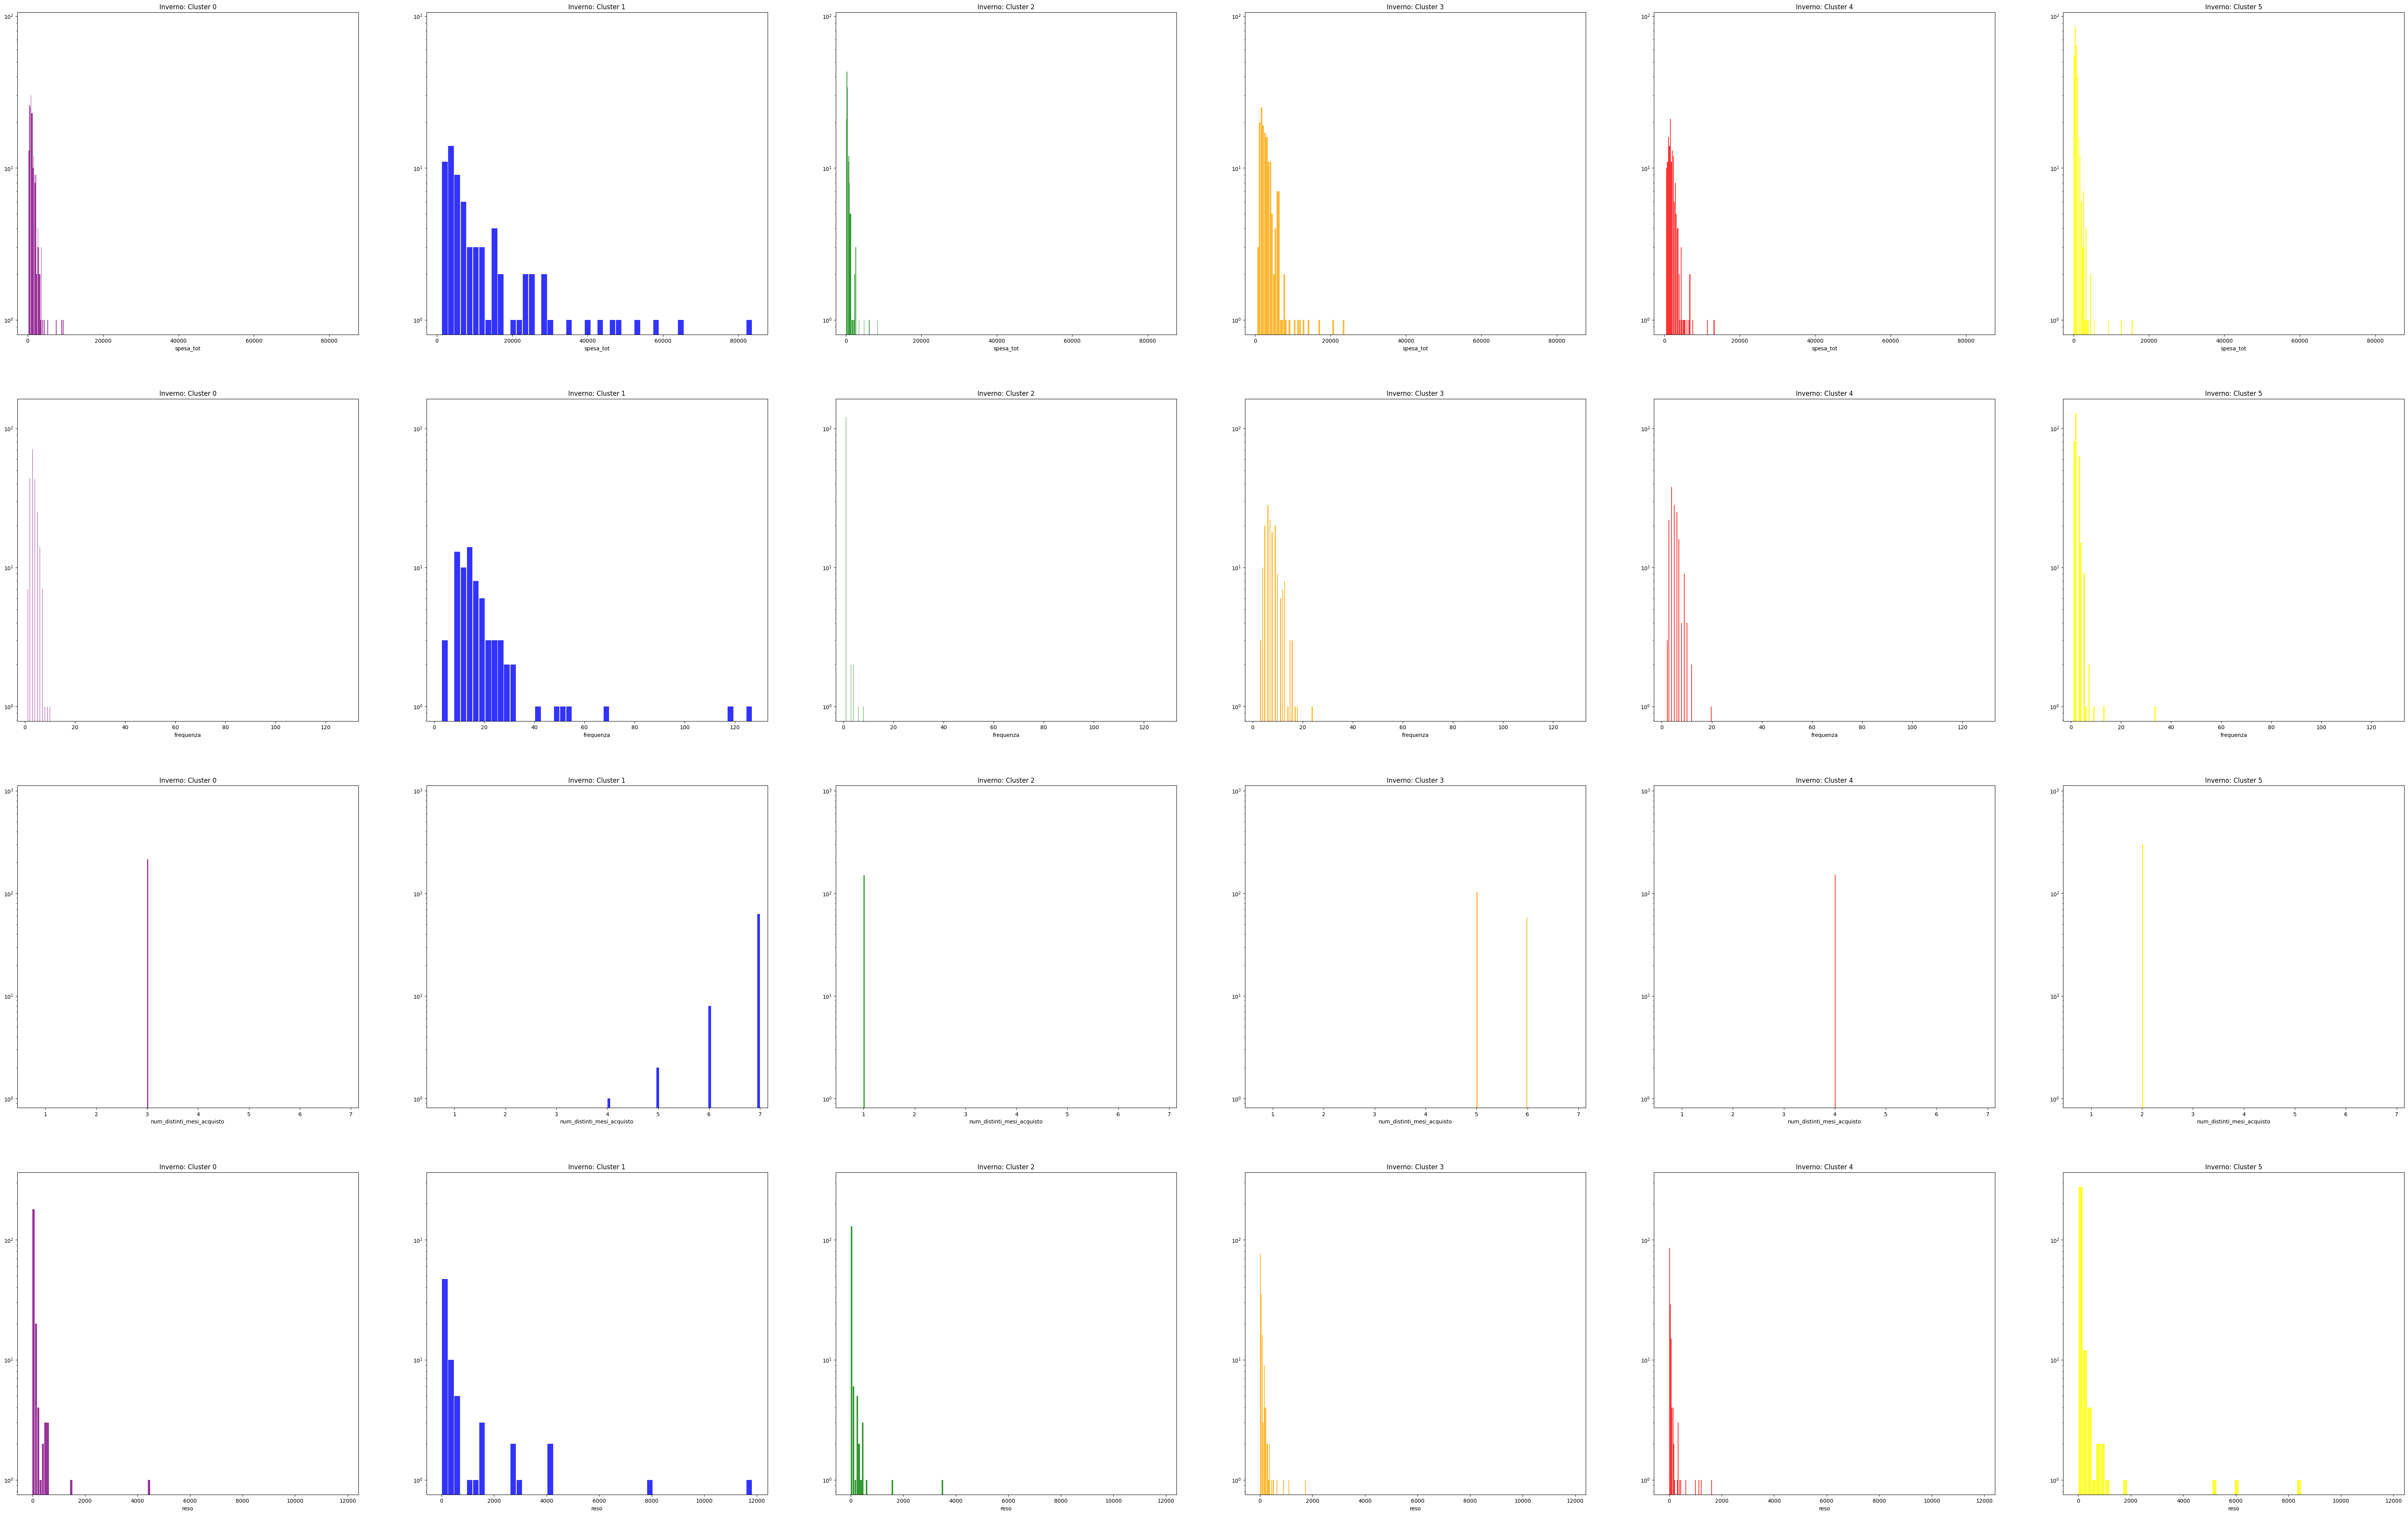

In [111]:
data = cluster_inv_norm
inverse_param = norm_value_inv

features = ['spesa_tot', 'frequenza', 'num_distinti_mesi_acquisto', 'reso']
stagione = 'Inverno'

cluster_dist(data, inverse_param, features, stagione)

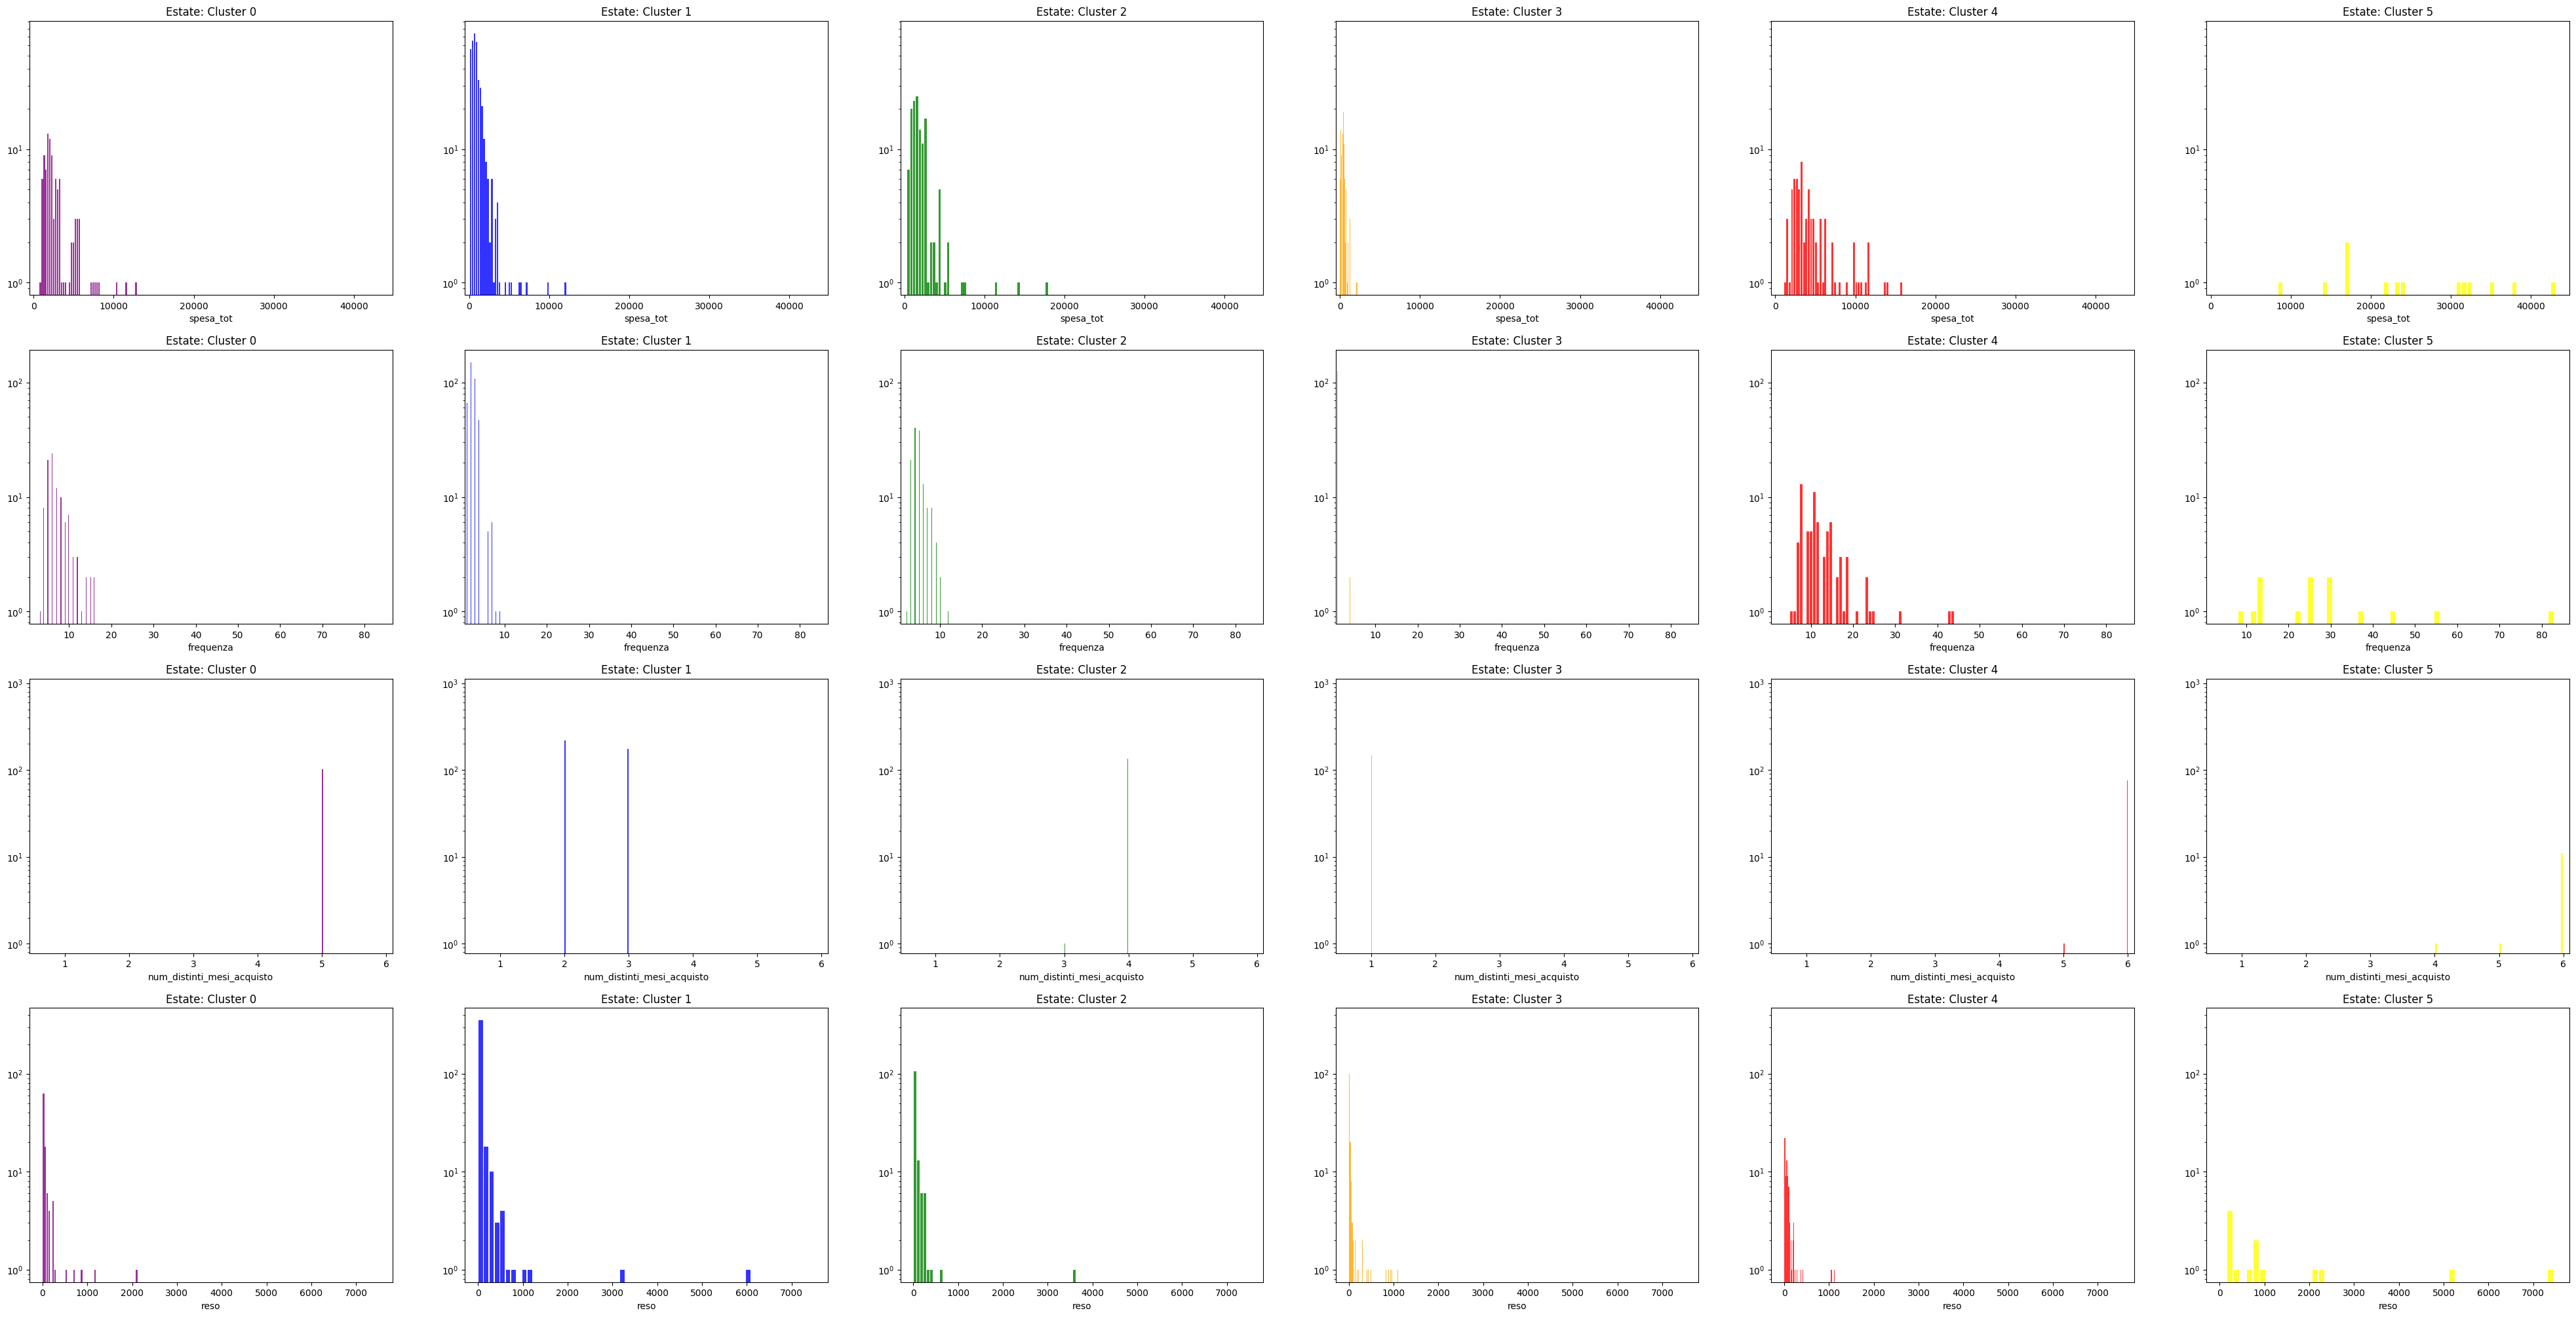

In [107]:
data = cluster_est_norm
inverse_param = norm_value_est

features = ['spesa_tot', 'frequenza', 'num_distinti_mesi_acquisto', 'reso']
stagione = 'Estate'

cluster_dist(data, inverse_param, features, stagione)

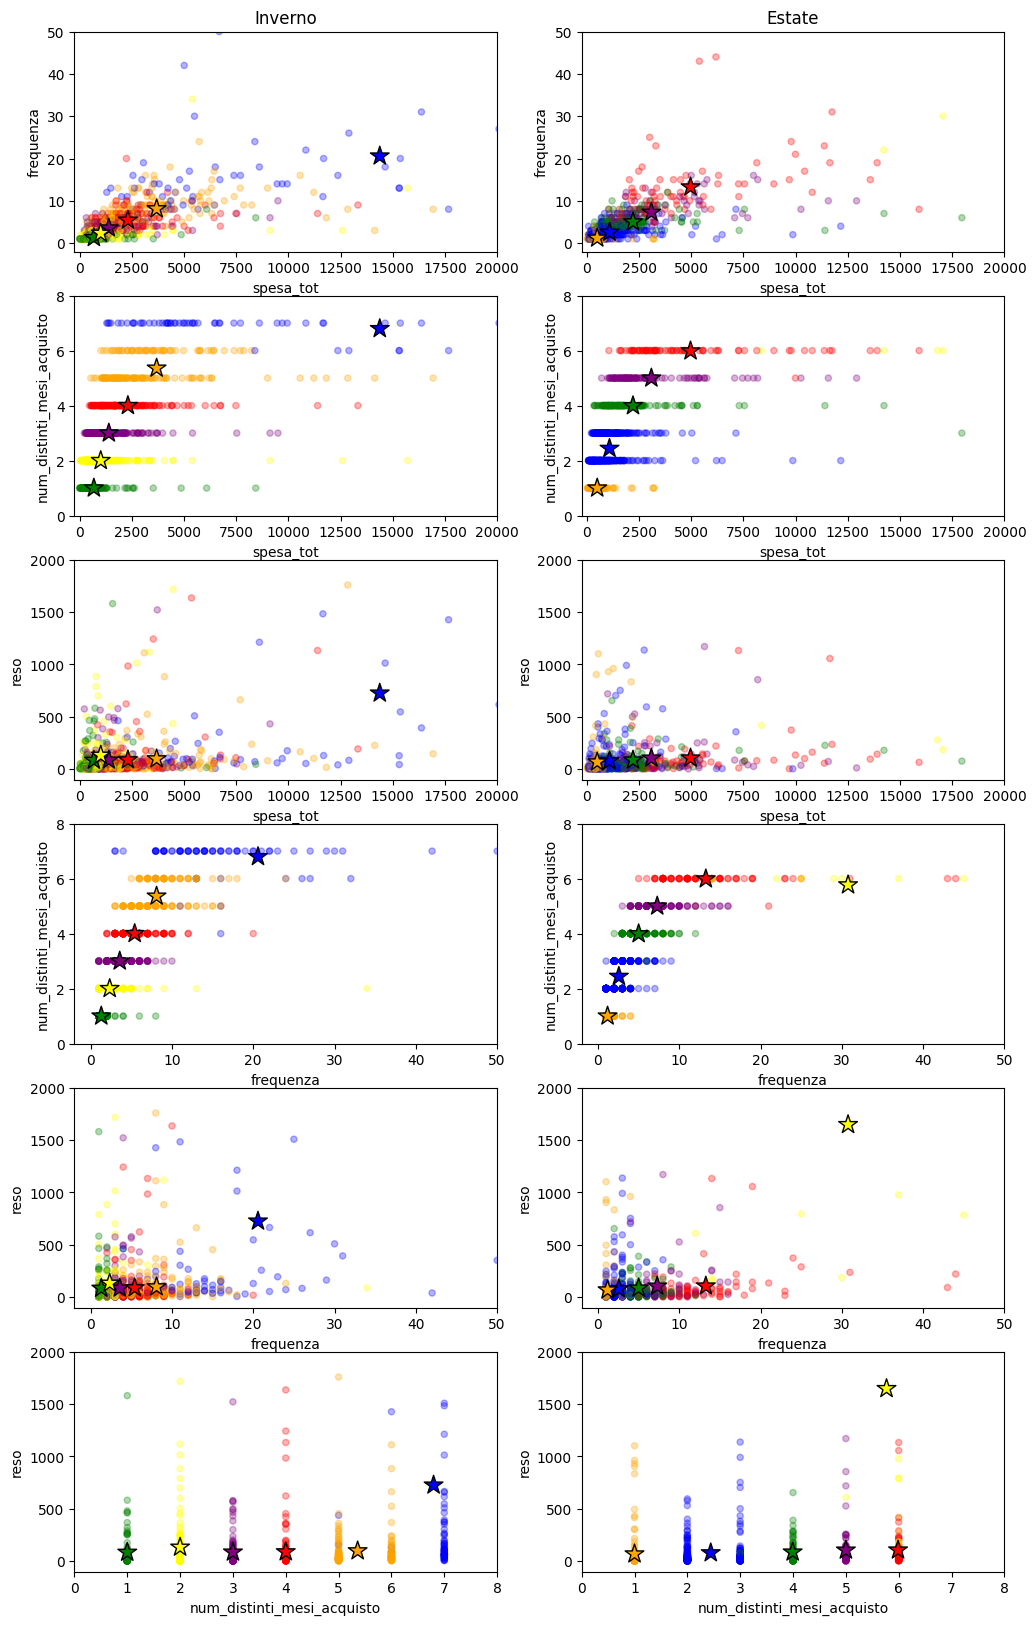

In [205]:
cols_name = ['spesa_tot', 'frequenza', 'num_distinti_mesi_acquisto', 'reso']
lim = [(-250, 20000), (-2, 50), (-0, 8), (-100, 2000)]
lim_d = dict(zip(cols_name, lim))

#  ['purple','blue','orange','green', 'red', 'yellow']
plot_clusters(df_inv, df_centroidi_inv, df_est, df_centroidi_est, lim_d)

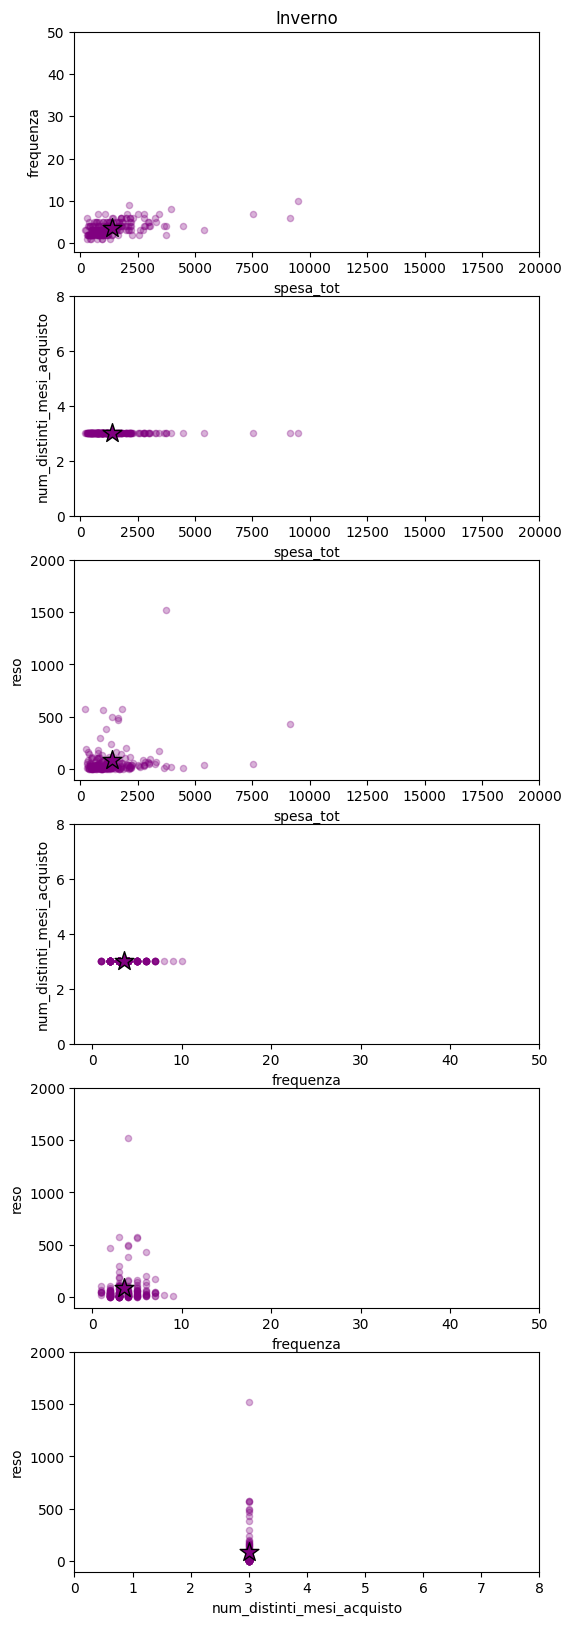

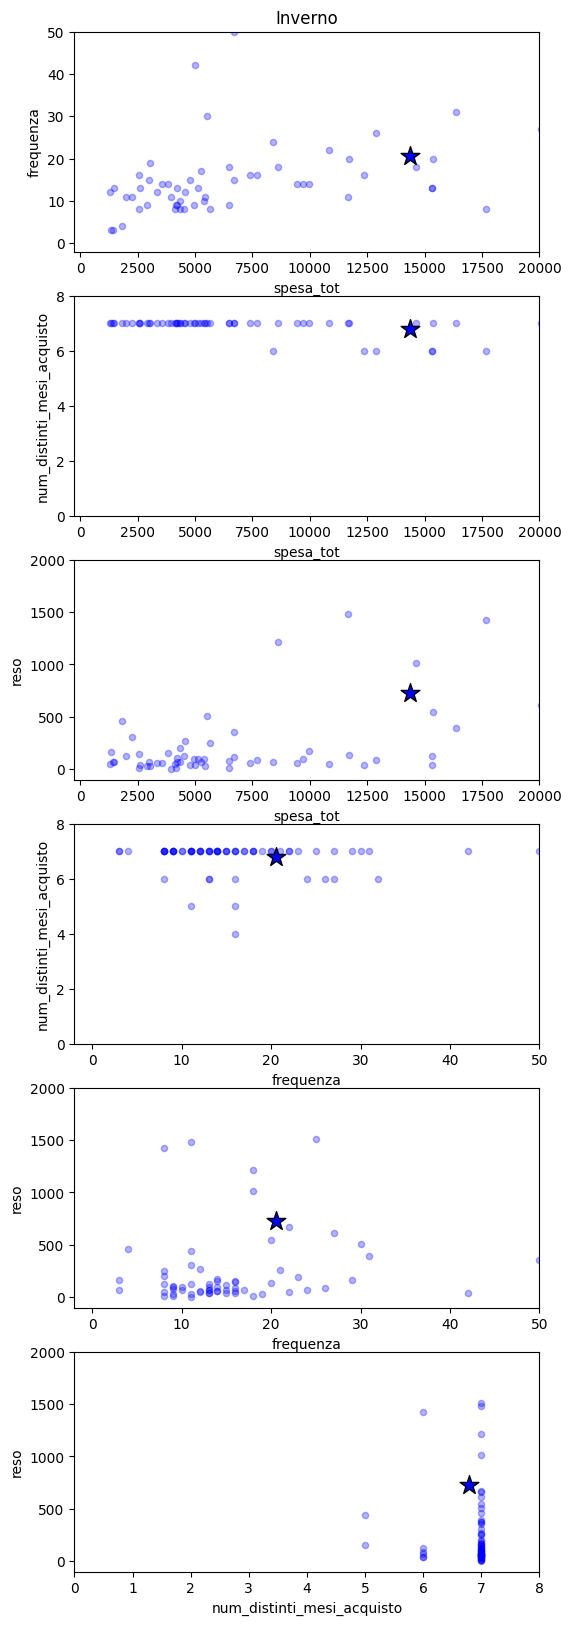

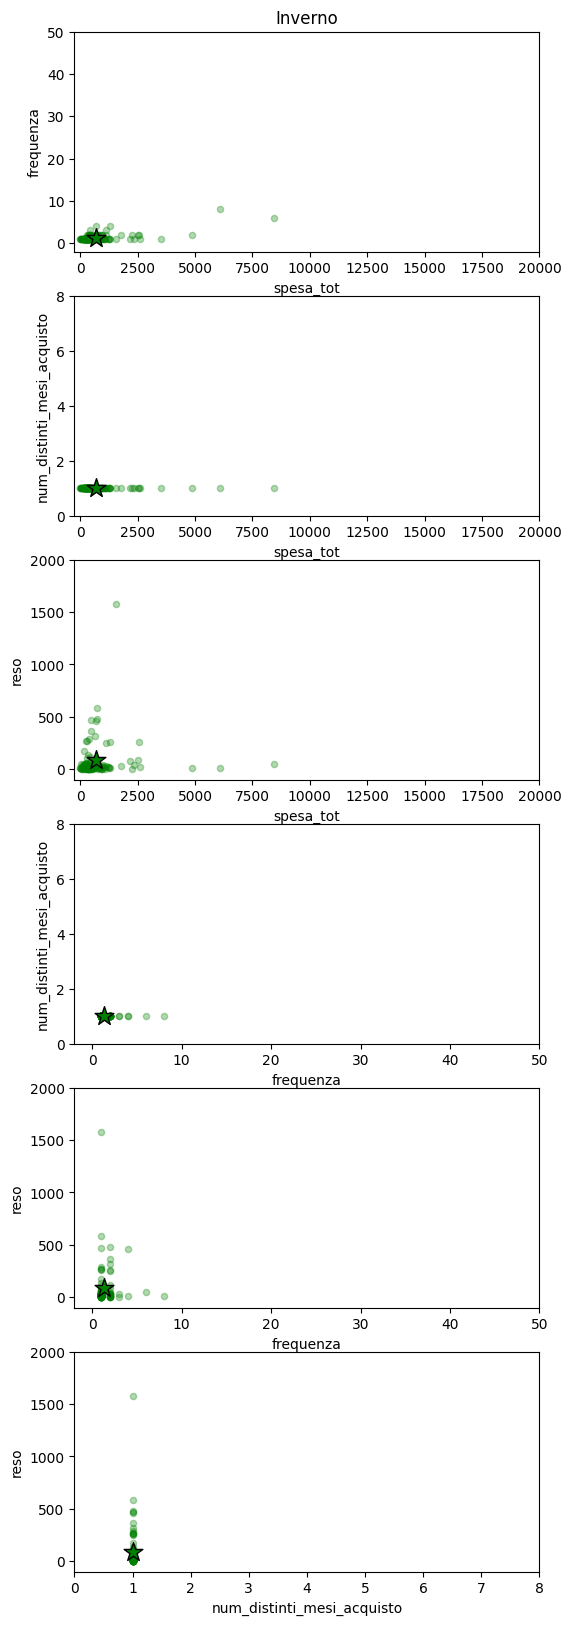

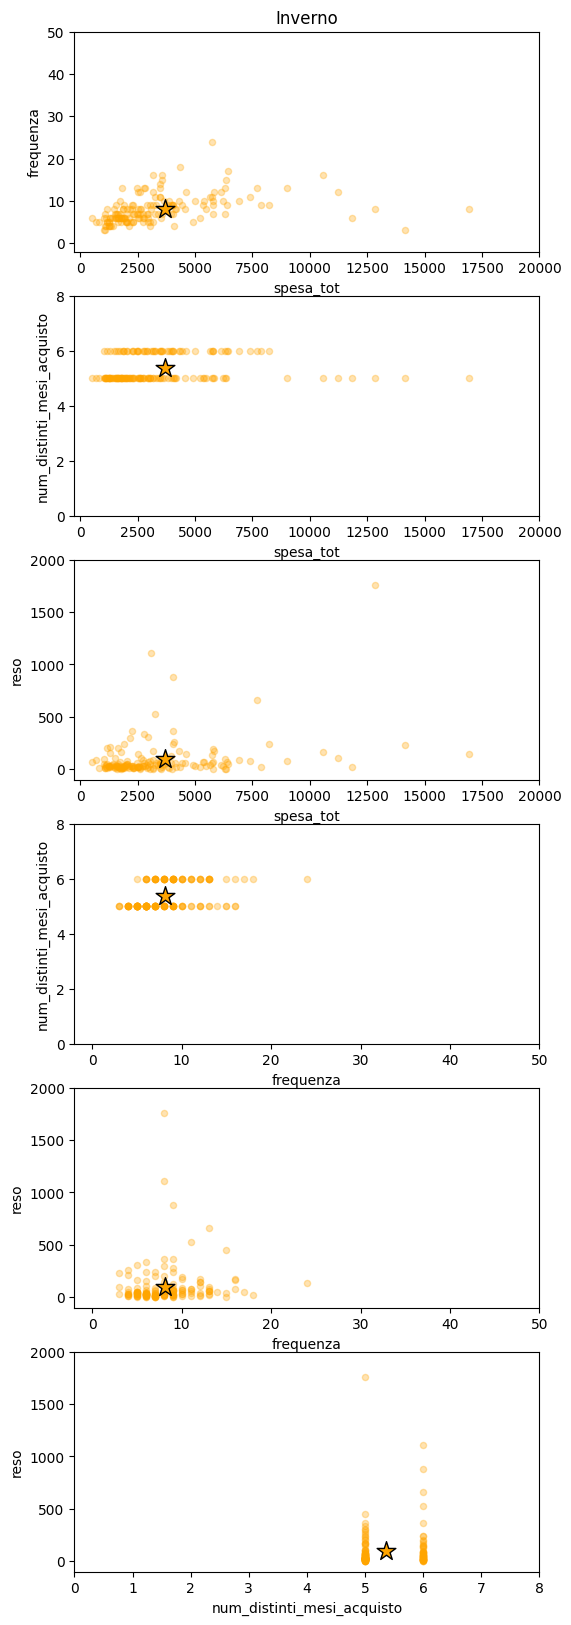

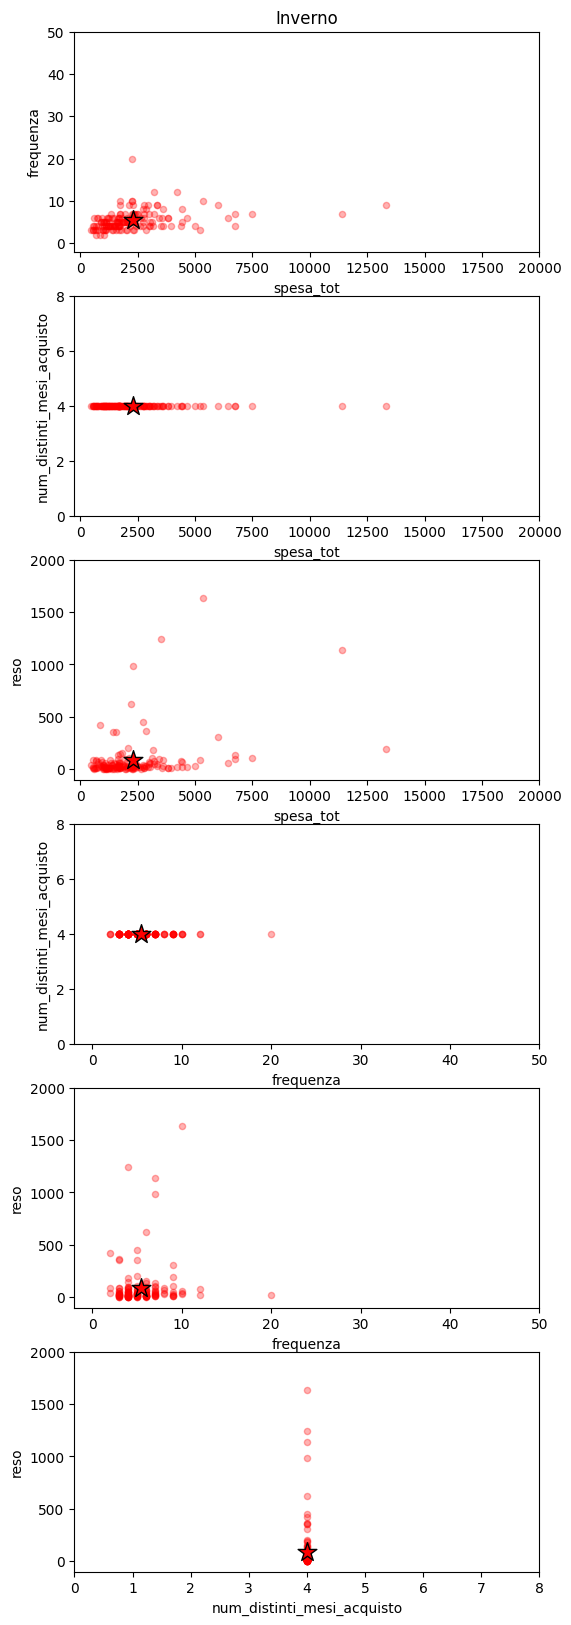

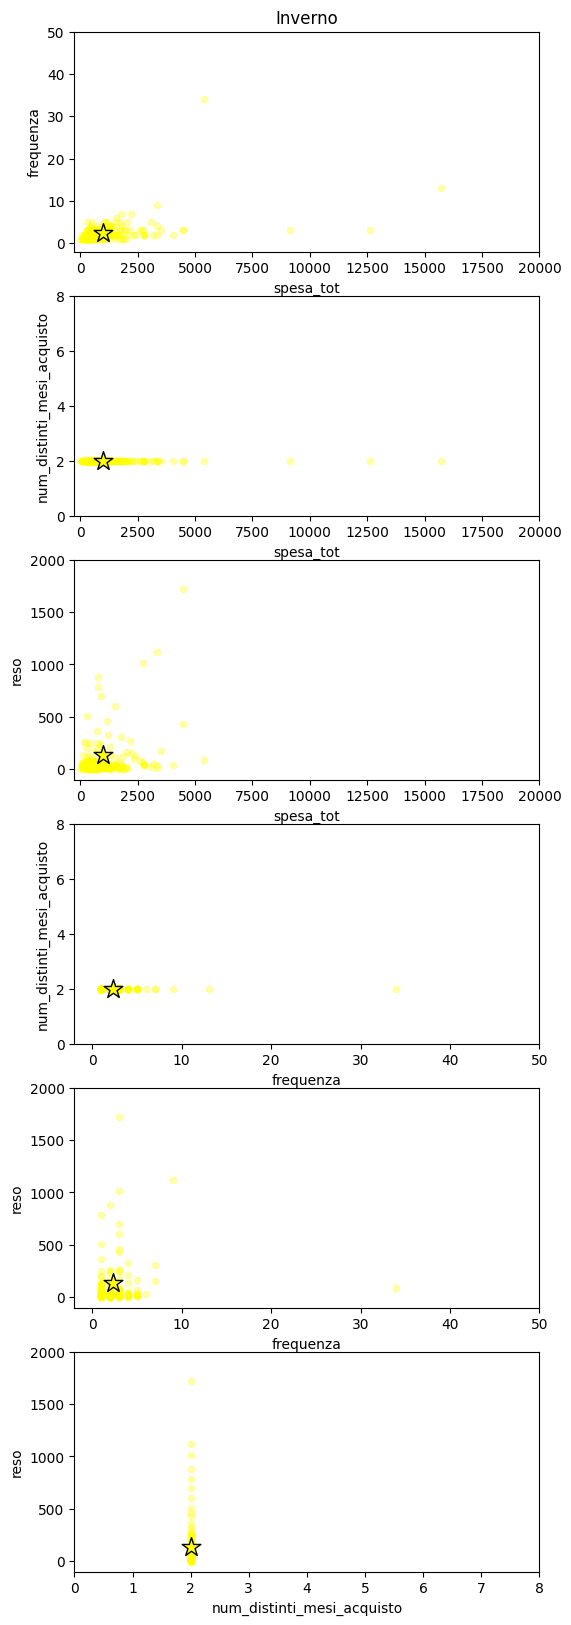

In [186]:
plot_per_cluster(df_inv, 'Inverno', lim_d, df_centroidi_inv)

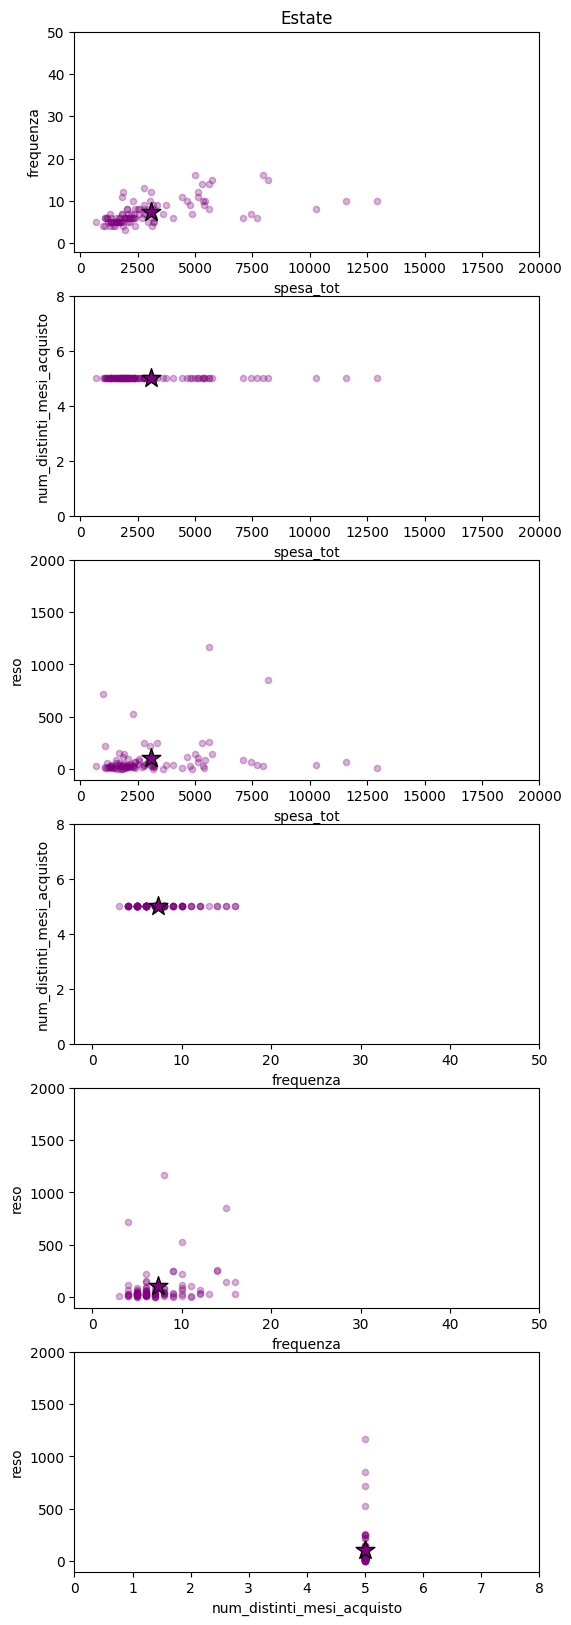

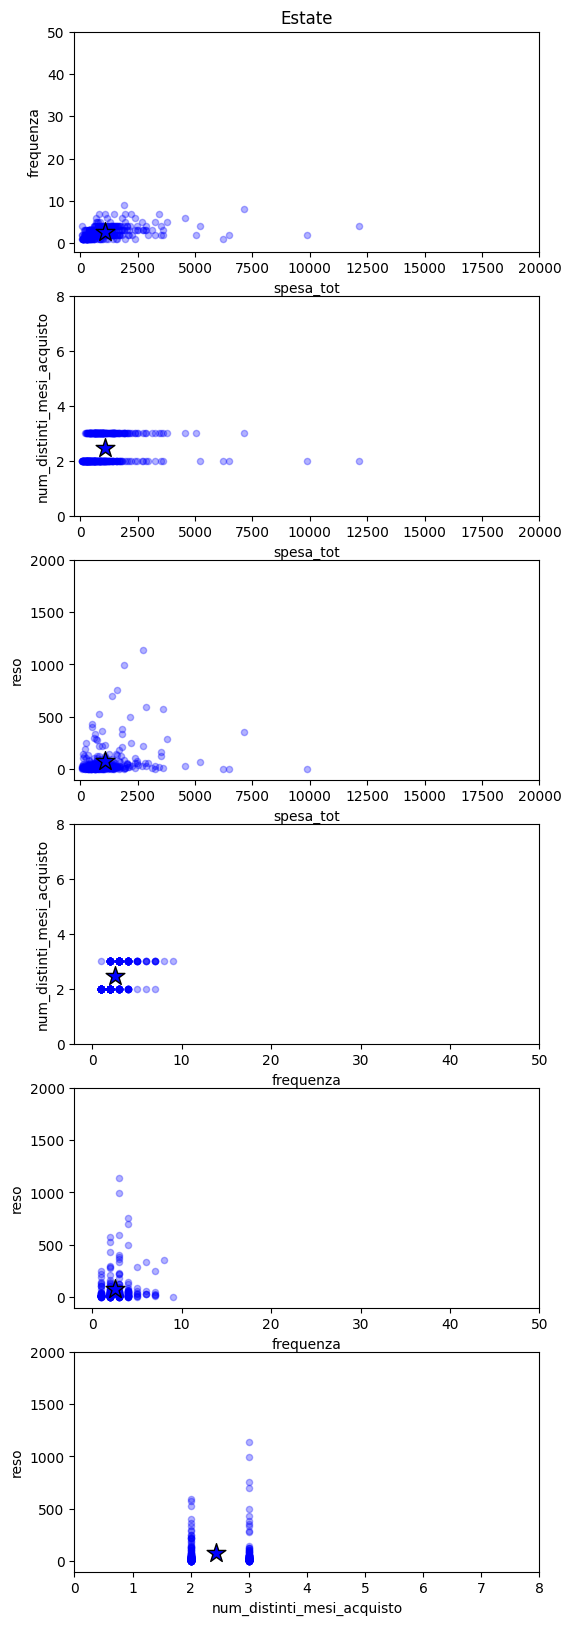

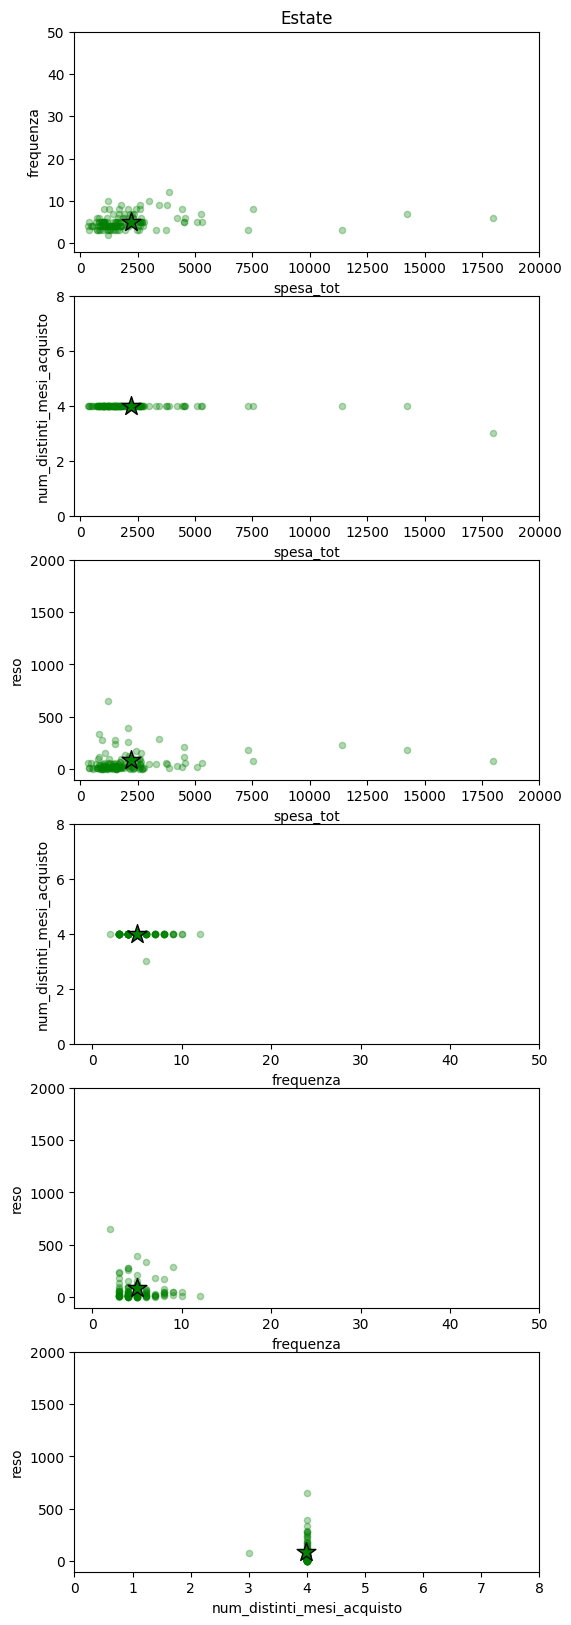

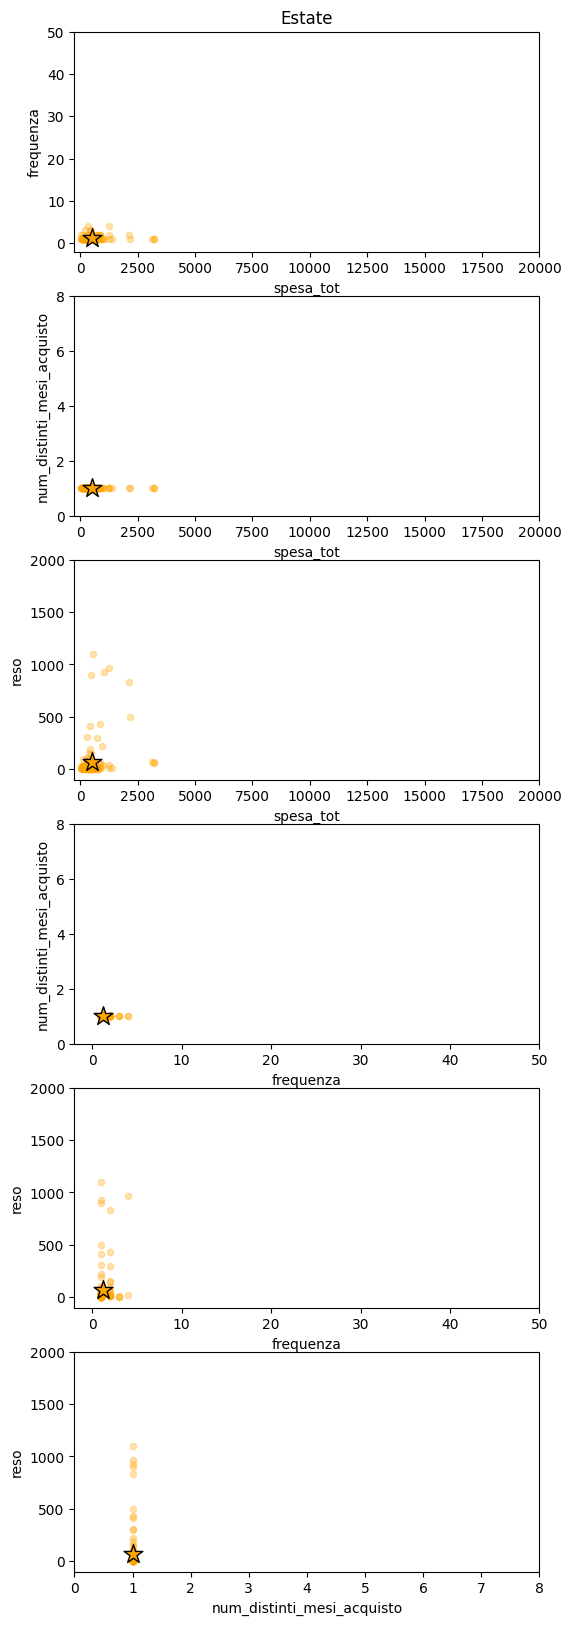

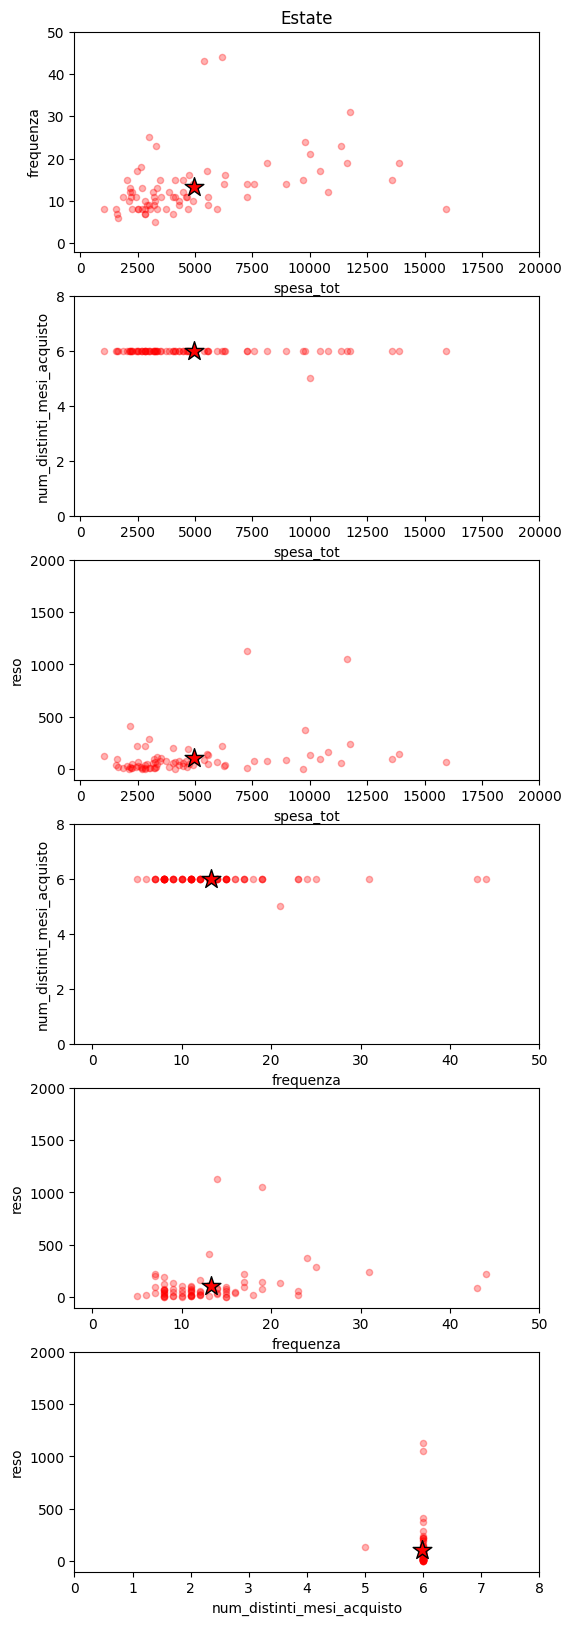

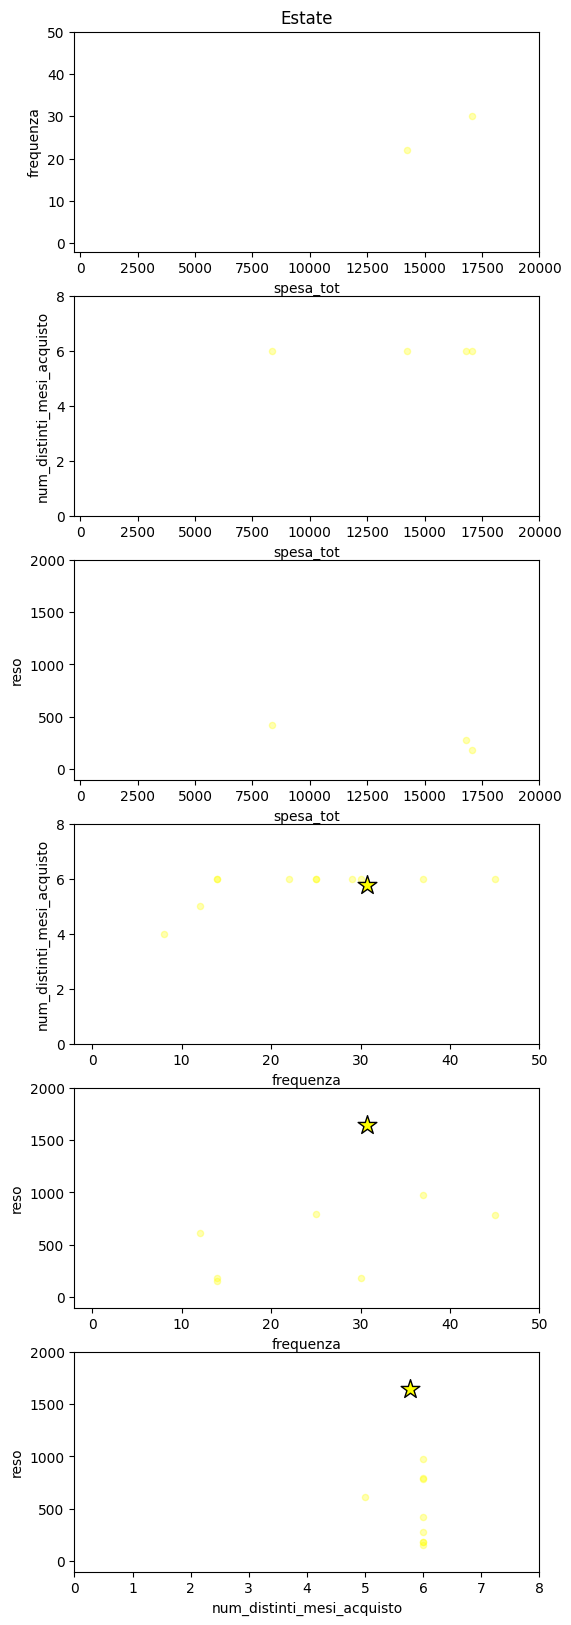

In [187]:
plot_per_cluster(df_est, 'Estate', lim_d, df_centroidi_est)

## Descrizione cluster

**Estate**
- 0 <i>-> big-spenders</i>
- 1 -> <i>lost</i>
- 2 -> <i>almost</i>
- 3 -> <i>lost-cheap</i>
- 4 -> <i>loyal</i>
- 5 -> <i>best</i>

**Inverno**
- 0 -> <i>almost</i>
- 1 -> <i>best</i>
- 2 -> <i>lost-cheap</i>
- 3 -> <i>loyal</i>
- 4 -> <i>big-spenders</i>
- 5 -> <i>lost</i>

In [158]:
# lista con 
dic_cl_descr_est = [13, 11, 12, 10, 14, 15]
dic_cl_descr_inv = [12, 15, 10, 14, 13, 11]

In [159]:
df_est['label_est'] = [dic_cl_descr_est[c] for c in df_est['label']]
df_inv['label_inv'] = [dic_cl_descr_inv[c] for c in df_inv['label']]

In [160]:
result = pd.merge(df_est[['customer', 'label_est']], df_inv[['label_inv', 'customer']],\
                on='customer', how='outer')

In [161]:
result.head()

,customer,label_est,label_inv
0,15194,13.0,14.0
1,18075,13.0,14.0
2,17738,11.0,NaN
3,17576,14.0,15.0
4,13230,12.0,NaN


In [162]:
totali = len(result)
customer_stesse_abitudini = result[result['label_est'] == result['label_inv']]
cust_tot = len(customer_stesse_abitudini)
print('Customer stesso tipo di cluster in estate e inverno {0} ({1}%)'.format(cust_tot, round(cust_tot/totali*100, 2)))

Customer stesso tipo di cluster in estate e inverno 108 (7.11%)


In [163]:
customer_cambiano_abitudini = result[((result['label_est'] != result['label_inv']) \
                                     & (result['label_est'].notna()) & (result['label_inv'].notna()))]
cust_tot = len(customer_cambiano_abitudini)
print('Customer con comportamenti diversi in estate e inverno {0} ({1}%)'.format(cust_tot, round(cust_tot/totali*100, 2)))

Customer con comportamenti diversi in estate e inverno 295 (19.42%)


In [164]:
customer_inv = result[result['label_est'].isna()]
cust_tot = len(customer_inv)
print('Customer solo inverno {0} ({1}%)'.format(cust_tot, round(cust_tot/totali*100, 2)))

Customer solo inverno 651 (42.86%)


In [165]:
customer_est = result[result['label_inv'].isna()]
cust_tot = len(customer_est)
print('Customer solo estate {0} ({1}%)'.format(cust_tot, round(cust_tot/totali*100, 2)))

Customer solo estate 465 (30.61%)


In [166]:
customer_cambiano_abitudini['label_diff'] = customer_cambiano_abitudini.apply(lambda row: (row.label_est - row.label_inv), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [167]:
customer_cambiano_abitudini[abs(customer_cambiano_abitudini['label_diff']) == 5].sort_values(by=['label_est'])

,customer,label_est,label_inv,label_diff
472,16191,10.0,15.0,-5.0
661,14096,10.0,15.0,-5.0


In [174]:
customer_cambiano_abitudini[abs(customer_cambiano_abitudini['label_diff']) == 3]

,customer,label_est,label_inv,label_diff
27,15687,11.0,14.0,-3.0
92,12362,11.0,14.0,-3.0
165,16150,11.0,14.0,-3.0
178,14188,11.0,14.0,-3.0
180,17451,10.0,13.0,-3.0
331,17888,11.0,14.0,-3.0
352,17659,11.0,14.0,-3.0
353,16161,12.0,15.0,-3.0
358,14842,10.0,13.0,-3.0
473,15298,11.0,14.0,-3.0


In [169]:
l1 = len(customer_cambiano_abitudini[customer_cambiano_abitudini['label_diff'] < 0])
l2 = len(customer_cambiano_abitudini[customer_cambiano_abitudini['label_diff'] > 0])
print('Customer (tra quelli che cambiano abitudine) che spendono di più in inverno che in estate', l1)
print('Customer (tra quelli che cambiano abitudine) che spendono di più in estate che in inverno', l2)

Customer (tra quelli che cambiano abitudine) che spendono di più in inverno che in estate 248
Customer (tra quelli che cambiano abitudine) che spendono di più in estate che in inverno 47


In [194]:
df_centroidi_inv

,spesa_tot,frequenza,num_distinti_mesi_acquisto,reso
0,1399.228037,3.574766,3.000000,85.535794
1,14377.724189,20.581081,6.797297,725.193919
2,682.353179,1.304636,1.000000,83.861788
3,3688.300745,8.105590,5.360248,97.695714
4,2312.842039,5.414474,4.000000,88.210329
5,1011.336556,2.341060,2.000000,132.396391


In [199]:
df_centroidi_est['percentuale_reso'] = df_centroidi_est.apply(lambda row: (row.reso/row.spesa_tot*100), axis=1)

In [ ]:
**Estate**
- 0 -> <i>big-spenders</i>
- 1 -> <i>lost</i>
- 2 -> <i>almost</i>
- 3 -> <i>lost-cheap</i>
- 4 -> <i>loyal</i>
- 5 -> <i>best</i>

**Inverno**
- 0 -> <i>almost</i>
- 1 -> <i>best</i>
- 2 -> <i>lost-cheap</i>
- 3 -> <i>loyal</i>
- 4 -> <i>big-spenders</i>
- 5 -> <i>lost</i>

In [200]:
df_centroidi_est

,spesa_tot,frequenza,num_distinti_mesi_acquisto,reso,percentuale_reso
0,3088.259608,7.294118,5.000000,104.533922,3.384881
1,1082.358908,2.575064,2.442748,78.676870,7.269019
2,2208.325956,5.007353,3.992647,85.907132,3.890147
3,494.616395,1.183673,1.000000,68.083673,13.764945
4,4964.163247,13.272727,5.987013,105.485974,2.124950
5,25865.438462,30.769231,5.769231,1646.334615,6.364998


In [ ]:
df_centroidi_inv['percentuale_reso'] = df_centroidi_inv.apply(lambda row: (row.reso/row.spesa_tot*100), axis=1)

In [198]:
df_centroidi_inv

,spesa_tot,frequenza,num_distinti_mesi_acquisto,reso,percentuale_reso
0,1399.228037,3.574766,3.000000,85.535794,6.113070
1,14377.724189,20.581081,6.797297,725.193919,5.043871
2,682.353179,1.304636,1.000000,83.861788,12.290085
3,3688.300745,8.105590,5.360248,97.695714,2.648800
4,2312.842039,5.414474,4.000000,88.210329,3.813937
5,1011.336556,2.341060,2.000000,132.396391,13.091230


In [88]:
sc.stop()